In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras import layers
from typing import List
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy

# !pip install torchmetrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load dataset

4422102/4422102 [==============================] - 0s 0us/step


9

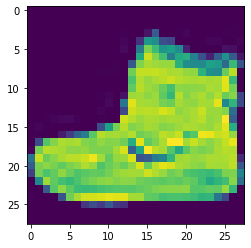

In [2]:
(x_train_initial, y_train), (x_test_initial, y_test) = tf.keras.datasets.fashion_mnist.load_data()
plt.imshow(x_train_initial[0]) #show first imagine 
y_train[0] #class label for image above

# Normalize dataset

In [3]:
x_train_unnormalized = x_train_initial.reshape(60000, 28**2)
x_test_unnormalized = x_test_initial.reshape(10000, 28**2)

x_train = (x_train_unnormalized - np.mean(x_train_unnormalized, axis=0))/np.std(x_train_unnormalized, axis=0)
x_test = (x_test_unnormalized - np.mean(x_test_unnormalized, axis=0))/np.std(x_test_unnormalized, axis=0)

x_train_u, x_valid_u, y_train_u, y_valid_u = train_test_split(x_train_unnormalized, y_train, train_size=0.8) #default shuffle=True
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, train_size=0.8) #default shuffle=True
y_train_conv, y_valid_conv, y_test_conv = y_train, y_valid, y_test

In [4]:
print(type(x_train))
print(x_train.shape)

<class 'numpy.ndarray'>
(48000, 784)


# Hot One Encode labels

In [5]:
y_train = np.eye(10)[y_train]
y_valid = np.eye(10)[y_valid]
y_test = np.eye(10)[y_test]
y_train_u = np.eye(10)[y_train_u]
y_valid_u = np.eye(10)[y_valid_u]


print(y_train.shape)

(48000, 10)


# Neural Network

## Neural Net Layer

In [6]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError
    

## Linear Layer

In [7]:

class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = 0.01 * np.random.randn(output_size, input_size)
        self.b = 0.01 * np.random.randn(output_size)

        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        dw = gradient[:, :, None] @ self.cur_input[:, None, :] 
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

In [8]:
# This is for higher layers

class LinearLayerX(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size

        self.w = 0.1 * np.random.randn(output_size, input_size)
        self.b = 0.1 * np.random.randn(output_size)

        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        dw = gradient[:, :, None] @ self.cur_input[:, None, :] 
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

## Relu Layer

In [9]:
    
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

## Softmax

In [10]:
    
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        x = x - np.max(x, axis=-1, keepdims=True)
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target


## Tanh

In [11]:
class tanhLayer(NeuralNetLayer):
  def __init__(self):
        super().__init__()

  def forward(self, x):
    self.gradient = 1 - (np.tanh(x))**2
    return np.tanh(x)
  
  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

## Leaky-ReLU

In [12]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, slope):
        super().__init__()
        self.slope = slope # For the negative part
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, self.slope)
        return np.maximum(0, x) + self.slope * np.minimum(0,x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

## Optimizer

In [13]:
class Optimizer:
    def __init__(self, net):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError()

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)


## Useful Functions

In [14]:
def ce(yhat, y, layers, alpha=0, l2=False):
    if l2:
      l2_norm = 0
      for layer in layers:
        if layer.parameters is not None:
          l2_norm += layer.w ** 2
          
      return -1 * np.sum(y * np.log(yhat + 1e-100))/len(y) + alpha * l2_norm

    else:
      return -1 * np.sum(y * np.log(yhat + 1e-100))/len(y)
    

def evaluate_acc(yhat, y): #they are one hot encoded
    yhat = np.argmax(yhat, axis=-1)
    y = np.argmax(y, axis=-1)
    return accuracy_score(yhat, y)

def ce_vs_epoch(losses, losses_valid=None, name=None, title=None):
    plt.clf()
    plt.plot(losses, label = "Train")
    if losses_valid is not None:
        plt.plot(losses_valid, label = "Valid")
    plt.xlabel("Epoch")
    plt.ylabel("CE loss")
    plt.title(f"CE vs Epoch: {title}")
    plt.legend(loc='top right')
    plt.savefig(f"training_vs_valid_CE_{name}.png", bbox_inches="tight", dpi=300)
    plt.show()

def acc_vs_epoch(acc, acc_valid=None, name=None, title=None):
    plt.clf()
    plt.plot(acc, label = "Train")
    if acc_valid is not None:
        plt.plot(acc_valid, label = "Valid")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.title(f"Accuracy vs Epoch: {title}")
    plt.savefig(f"training_vs_valid_acc_{name}.png", bbox_inches="tight", dpi=300)
    plt.show()



## MLP

In [15]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args
        self.best = None

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        self.out = x
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
            
    def fit(self, optimizer, x_train, y_train, x_valid, y_valid, alpha=0, l2 = False, steps = 50, batch_size = 100):
        losses, losses_valid, acc_train, acc_valid = [], [], [], []
        lowest_ce = math.inf
        
        for iteration in tqdm(range(steps)):
            batch_loss = []
            batch_accuracy = []
            for i in range(0, x_train.shape[0], batch_size):
                batch_x = x_train[i:i+batch_size]
                labels_y = y_train[i:i+batch_size]
                yhat = self.predict(batch_x) #default testing=False
                b_loss = ce(yhat, labels_y, self.layers, l2)
                b_accuracy = evaluate_acc(yhat, labels_y)
                self.backward(labels_y)
                optimizer.step()
                batch_loss.append(b_loss)
                batch_accuracy.append(b_accuracy)
            
            #average training loss and accuracy
            loss = sum(batch_loss)/len(batch_loss)
            losses.append(loss)
            accuracy_train = sum(batch_accuracy)/len(batch_accuracy)
            acc_train.append(accuracy_train)
          
            #valid set
            predictions_valid = self.predict(x_valid)
            loss_valid = ce(predictions_valid, y_valid, self.layers, l2)
            losses_valid.append(loss_valid)
            accuracy_valid = evaluate_acc(predictions_valid, y_valid)
            acc_valid.append(accuracy_valid)
            
            if loss_valid < lowest_ce:
                lowest_ce = loss_valid
                self.best = deepcopy(self.layers)
            
            print("iteration {0}: train loss {1}, train acc {2}, valid loss {3}, valid acc {4} ".format(iteration, loss, accuracy_train, loss_valid, accuracy_valid))
        return self, losses, losses_valid, acc_train, acc_valid

    def predict(self, x_test, testing=False):
        if testing:
            for layer in self.best:
                x_test = layer.forward(x_test)
            return x_test
        return self.forward(x_test)
        
    def check_gradient(self, x, y):
        grads_w, grads_b = [], []
        for layer in self.layers:
            if not isinstance(layer, LinearLayer): #need layer.no and layer.ni
                continue
            eps_w = np.random.rand(layer.no, layer.ni) * 1e-19
            eps_b = np.random.rand(layer.no) * 1e-16
            
            #w - eps
            layer.w -= eps_w
            yhat = self.forward(x)
            ce1 = ce(y = y, yhat = yhat, layers = self.layers)
            
            #w + eps
            layer.w += 2*eps_w
            yhat = self.forward(x)
            ce2 = ce(y = y, yhat = yhat, layers = self.layers)
            layer.w -= eps_w #reset weights
            
            dw_num = (ce1 - ce2)/(2*eps_w) # approximated gradient
            dw_cal = layer.gradient[0].mean(axis=0)
            grad_diff = (dw_cal - dw_num)**2
            grad_diff = grad_diff/(dw_cal + dw_num)**2
            grads_w.append(eps_w.mean())
            grads_b.append(eps_b.mean())
        s = "Weight gradient difference: {}\n".format(grads_w)
        s += "Biases gradient difference: {}".format(grads_b)
        print(s)
        return grads_w, grads_b
    
         

# Task 3.1

Initialize features

In [16]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 15
BATCH_SIZE = 100
LEAKY_SLOPE = 1e-2
LEARNING_RATE = 1e-2

acc_train_layers = []
acc_test_layers = []

train_acc_layers = []
valid_test_acc_layers = []

## 0 Layer MLP

  7%|▋         | 1/15 [00:07<01:40,  7.20s/it]

iteration 0: train loss 0.6459978785805744, train acc 0.7888749999999997, valid loss 0.5214195217174805, valid acc 0.8238333333333333 


 13%|█▎        | 2/15 [00:12<01:21,  6.28s/it]

iteration 1: train loss 0.4946696372310381, train acc 0.8341666666666666, valid loss 0.4816971325899262, valid acc 0.8365 


 20%|██        | 3/15 [00:16<01:03,  5.29s/it]

iteration 2: train loss 0.46552453939479543, train acc 0.8430416666666665, valid loss 0.46431638447808543, valid acc 0.8440833333333333 


 27%|██▋       | 4/15 [00:21<00:55,  5.04s/it]

iteration 3: train loss 0.44977768437671833, train acc 0.8480416666666668, valid loss 0.4541328916996979, valid acc 0.847 


 33%|███▎      | 5/15 [00:24<00:43,  4.39s/it]

iteration 4: train loss 0.4393244939368789, train acc 0.8512500000000004, valid loss 0.4473509872800727, valid acc 0.8489166666666667 


 40%|████      | 6/15 [00:27<00:35,  3.96s/it]

iteration 5: train loss 0.4316467494228906, train acc 0.8529166666666673, valid loss 0.44247623916542966, valid acc 0.84975 


 47%|████▋     | 7/15 [00:31<00:29,  3.71s/it]

iteration 6: train loss 0.4256482905345233, train acc 0.8545833333333341, valid loss 0.4387881546275758, valid acc 0.85125 


 53%|█████▎    | 8/15 [00:34<00:24,  3.56s/it]

iteration 7: train loss 0.42076241381776397, train acc 0.8562291666666678, valid loss 0.43589581945964245, valid acc 0.8521666666666666 


 60%|██████    | 9/15 [00:37<00:20,  3.43s/it]

iteration 8: train loss 0.41666130054036166, train acc 0.8577500000000007, valid loss 0.43356823149834794, valid acc 0.8530833333333333 


 67%|██████▋   | 10/15 [00:40<00:16,  3.36s/it]

iteration 9: train loss 0.4131409003898875, train acc 0.8586250000000004, valid loss 0.431658255861043, valid acc 0.85325 


 73%|███████▎  | 11/15 [00:43<00:13,  3.30s/it]

iteration 10: train loss 0.410066075482458, train acc 0.8594375000000004, valid loss 0.43006629580541916, valid acc 0.8546666666666667 


 80%|████████  | 12/15 [00:47<00:09,  3.28s/it]

iteration 11: train loss 0.4073427538297246, train acc 0.8603333333333336, valid loss 0.4287223482924729, valid acc 0.85525 


 87%|████████▋ | 13/15 [00:50<00:06,  3.25s/it]

iteration 12: train loss 0.40490310781262434, train acc 0.8611666666666667, valid loss 0.4275759089390987, valid acc 0.85525 


 93%|█████████▎| 14/15 [00:53<00:03,  3.27s/it]

iteration 13: train loss 0.40269679993839613, train acc 0.8619583333333333, valid loss 0.42658966813769633, valid acc 0.8560833333333333 


100%|██████████| 15/15 [00:56<00:00,  3.79s/it]

iteration 14: train loss 0.4006855421135357, train acc 0.8625624999999998, valid loss 0.42573541140906385, valid acc 0.856 
[0.6459978785805744, 0.4946696372310381, 0.46552453939479543, 0.44977768437671833, 0.4393244939368789, 0.4316467494228906, 0.4256482905345233, 0.42076241381776397, 0.41666130054036166, 0.4131409003898875, 0.410066075482458, 0.4073427538297246, 0.40490310781262434, 0.40269679993839613, 0.4006855421135357]


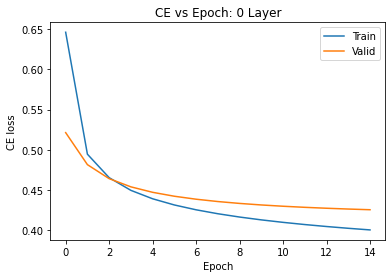

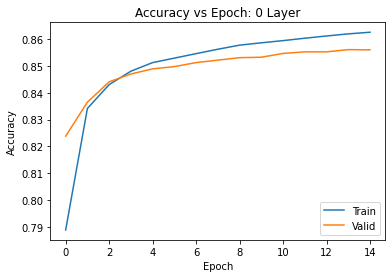

In [17]:
mlp0 = MLP(LinearLayer(28**2, 10),
           SoftmaxOutputLayer()
)

opt0 = GradientDescentOptimizer(mlp0, LEARNING_RATE)
mlp, losses_train, losses_valid, acc_train, acc_valid = mlp0.fit(opt0, x_train, y_train, x_valid, y_valid, steps=GRADIENT_STEPS, batch_size=BATCH_SIZE)

train_acc_layers.append(acc_train)
valid_test_acc_layers.append(acc_valid)

print(losses_train)
ce_vs_epoch(losses_train, losses_valid, "0_layer", "0 Layer")
acc_vs_epoch(acc_train, acc_valid, "0_layer", "0 Layer")

### 0 Layer Training Accuracy

In [18]:
predictions = mlp.predict(x_train, testing=True)
acc = evaluate_acc(predictions, y_train)
acc_train_layers.append(acc)
print("Training accuracy with 0 layer mlp: ", acc)

Training accuracy with 0 layer mlp:  0.8639375


### 0 Layer Testing Accuracy

In [19]:
predictions = mlp.predict(x_test, testing=True)
acc = evaluate_acc(predictions, y_test)
acc_test_layers.append(acc)
print("Testing accuracy with 0 mlp: ", acc)

Testing accuracy with 0 mlp:  0.8411


### Check Gradient

In [20]:
grads = mlp.check_gradient(x_train, y_train)

Weight gradient difference: [5.022308871896371e-20]
Biases gradient difference: [6.228105883666249e-17]


## 1 Layer MLP

In [21]:
mlp1 = MLP(
    LinearLayer(28**2, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, LEARNING_RATE)


  7%|▋         | 1/15 [00:34<07:58, 34.19s/it]

iteration 0: train loss 1.252022380361623, train acc 0.6249583333333332, valid loss 0.716534636011084, valid acc 0.75 


 13%|█▎        | 2/15 [01:08<07:24, 34.19s/it]

iteration 1: train loss 0.6198396445530193, train acc 0.775145833333333, valid loss 0.5583516858725585, valid acc 0.79625 


 20%|██        | 3/15 [01:42<06:49, 34.16s/it]

iteration 2: train loss 0.5193800783893378, train acc 0.8116875000000001, valid loss 0.4946486520255576, valid acc 0.8209166666666666 


 27%|██▋       | 4/15 [02:16<06:14, 34.06s/it]

iteration 3: train loss 0.4706475905771311, train acc 0.8315833333333342, valid loss 0.4599098137414615, valid acc 0.8333333333333334 


 33%|███▎      | 5/15 [02:51<05:44, 34.47s/it]

iteration 4: train loss 0.4419438887418614, train acc 0.8434374999999996, valid loss 0.4384752347198474, valid acc 0.8410833333333333 


 40%|████      | 6/15 [03:25<05:07, 34.17s/it]

iteration 5: train loss 0.42239748226489404, train acc 0.8499583333333335, valid loss 0.4233570531993264, valid acc 0.8474166666666667 


 47%|████▋     | 7/15 [03:59<04:32, 34.12s/it]

iteration 6: train loss 0.4075450847356368, train acc 0.8553124999999999, valid loss 0.41183433014934756, valid acc 0.8523333333333334 


 53%|█████▎    | 8/15 [04:32<03:57, 33.93s/it]

iteration 7: train loss 0.39547050607836215, train acc 0.8590208333333333, valid loss 0.4025703059247271, valid acc 0.85475 


 60%|██████    | 9/15 [05:05<03:22, 33.69s/it]

iteration 8: train loss 0.3852664644911424, train acc 0.8622708333333338, valid loss 0.39494817639117097, valid acc 0.8585 


 67%|██████▋   | 10/15 [05:39<02:48, 33.61s/it]

iteration 9: train loss 0.37646511410304656, train acc 0.8657500000000007, valid loss 0.38844103504328087, valid acc 0.8613333333333333 


 73%|███████▎  | 11/15 [06:13<02:14, 33.65s/it]

iteration 10: train loss 0.3686959751179375, train acc 0.8682708333333338, valid loss 0.38282393323917524, valid acc 0.8636666666666667 


 80%|████████  | 12/15 [06:46<01:40, 33.61s/it]

iteration 11: train loss 0.36172037083198216, train acc 0.8707916666666663, valid loss 0.3778298683732679, valid acc 0.8650833333333333 


 87%|████████▋ | 13/15 [07:21<01:08, 34.04s/it]

iteration 12: train loss 0.3554015116269992, train acc 0.8730416666666663, valid loss 0.37343937829374446, valid acc 0.8670833333333333 


 93%|█████████▎| 14/15 [07:55<00:34, 34.08s/it]

iteration 13: train loss 0.34967475667949516, train acc 0.8749791666666664, valid loss 0.3695469513091352, valid acc 0.86925 


100%|██████████| 15/15 [08:31<00:00, 34.11s/it]

iteration 14: train loss 0.34439023320606527, train acc 0.8770416666666669, valid loss 0.3660477664706496, valid acc 0.8701666666666666 


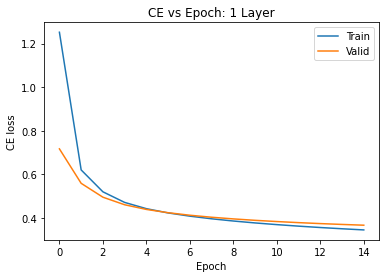

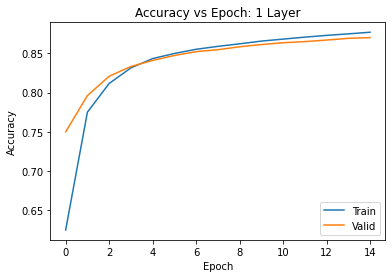

In [22]:
mlp, losses_train, losses_valid, acc_train, acc_valid = mlp1.fit(opt1, x_train, y_train, x_valid, y_valid, steps=GRADIENT_STEPS, batch_size = BATCH_SIZE)

train_acc_layers.append(acc_train)
valid_test_acc_layers.append(acc_valid)

ce_vs_epoch(losses_train, losses_valid, "1_layer", "1 Layer")
acc_vs_epoch(acc_train, acc_valid, "1_layer", "1 Layer")

### Training Accuracy

In [23]:
predictions = mlp.predict(x_train, testing=True)
acc = evaluate_acc(predictions, y_train)
acc_train_layers.append(acc)
print("Training accuracy with 1 layer mlp: ", acc)

Training accuracy with 1 layer mlp:  0.8785416666666667


### Testing Accuracy

In [24]:
predictions = mlp.predict(x_test, testing=True)
acc = evaluate_acc(predictions, y_test)
acc_test_layers.append(acc)
print("Testing accuracy with 1 layer mlp: ", acc)

Testing accuracy with 1 layer mlp:  0.8561


### Check Gradient

In [25]:
grads = mlp.check_gradient(x_train, y_train)

Weight gradient difference: [4.9933636383724567e-20, 5.148365843180111e-20]
Biases gradient difference: [4.99886762913735e-17, 7.836329201558964e-17]


## 2 Layer MLP

In [26]:
mlp2 = MLP(
    LinearLayer(28**2, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, LEARNING_RATE)

  7%|▋         | 1/15 [00:40<09:29, 40.65s/it]

iteration 0: train loss 2.296863327064108, train acc 0.2550833333333333, valid loss 2.2835454738879193, valid acc 0.36233333333333334 


 13%|█▎        | 2/15 [01:21<08:46, 40.49s/it]

iteration 1: train loss 1.969307763467743, train acc 0.3262708333333328, valid loss 1.4130204538351638, valid acc 0.41658333333333336 


 20%|██        | 3/15 [02:01<08:05, 40.44s/it]

iteration 2: train loss 1.1047707123183956, train acc 0.5401875000000003, valid loss 0.914444667921572, valid acc 0.6680833333333334 


 27%|██▋       | 4/15 [02:43<07:30, 40.98s/it]

iteration 3: train loss 0.7753056233437604, train acc 0.713875, valid loss 0.6813647400841495, valid acc 0.7465833333333334 


 33%|███▎      | 5/15 [03:24<06:52, 41.22s/it]

iteration 4: train loss 0.6289463333701313, train acc 0.7572083333333334, valid loss 0.6003199700286294, valid acc 0.768 


 40%|████      | 6/15 [04:06<06:12, 41.39s/it]

iteration 5: train loss 0.5691605769012885, train acc 0.7767083333333322, valid loss 0.5559437266375786, valid acc 0.7845833333333333 


 47%|████▋     | 7/15 [04:47<05:30, 41.31s/it]

iteration 6: train loss 0.5307660622918214, train acc 0.7933124999999998, valid loss 0.5246808674281789, valid acc 0.7989166666666667 


 53%|█████▎    | 8/15 [05:28<04:48, 41.27s/it]

iteration 7: train loss 0.5013154489636028, train acc 0.8112291666666668, valid loss 0.49873741687397355, valid acc 0.8149166666666666 


 60%|██████    | 9/15 [06:09<04:06, 41.09s/it]

iteration 8: train loss 0.47560642889608146, train acc 0.8263958333333331, valid loss 0.47574626214814475, valid acc 0.8278333333333333 


 67%|██████▋   | 10/15 [06:51<03:26, 41.32s/it]

iteration 9: train loss 0.45311796553576766, train acc 0.8366041666666667, valid loss 0.456089139921395, valid acc 0.8365 


 73%|███████▎  | 11/15 [07:34<02:47, 41.93s/it]

iteration 10: train loss 0.43368258197216714, train acc 0.8440208333333342, valid loss 0.4392390604027943, valid acc 0.8433333333333334 


 80%|████████  | 12/15 [08:15<02:04, 41.53s/it]

iteration 11: train loss 0.41668888167380136, train acc 0.8498333333333332, valid loss 0.4247543791642955, valid acc 0.8484166666666667 


 87%|████████▋ | 13/15 [08:55<01:22, 41.24s/it]

iteration 12: train loss 0.40161266562492864, train acc 0.855437500000001, valid loss 0.41220305345547203, valid acc 0.853 


 93%|█████████▎| 14/15 [09:36<00:41, 41.13s/it]

iteration 13: train loss 0.3883752992638687, train acc 0.8598125000000003, valid loss 0.40152952454836516, valid acc 0.8573333333333333 


100%|██████████| 15/15 [10:18<00:00, 41.22s/it]

iteration 14: train loss 0.3769751651012371, train acc 0.8644166666666668, valid loss 0.39259401022333534, valid acc 0.8598333333333333 


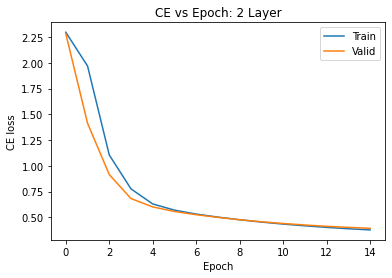

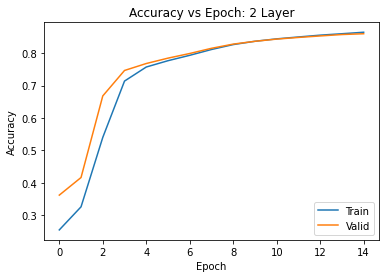

In [27]:
mlp, losses_train, losses_valid, acc_train, acc_valid = mlp2.fit(opt2, x_train, y_train, x_valid, y_valid, steps = GRADIENT_STEPS, batch_size=BATCH_SIZE)

train_acc_layers.append(acc_train)
valid_test_acc_layers.append(acc_valid)

ce_vs_epoch(losses_train, losses_valid, "2_layer", "2 Layer")
acc_vs_epoch(acc_train, acc_valid, "2_layer", "2 Layer")

### Training Accuracy

In [28]:
predictions = mlp.predict(x_train, testing=True)
acc = evaluate_acc(predictions, y_train)
acc_train_layers.append(acc)
print("Training Accuracy with 2 layer MLP: ", acc)

Training Accuracy with 2 layer MLP:  0.8670416666666667


### Testing Accuracy

In [29]:
predictions = mlp.predict(x_test, testing=True)
acc = evaluate_acc(predictions, y_test)
acc_test_layers.append(acc)
print("Testing Accuracy with 2 layer MLP: ", acc)

Testing Accuracy with 2 layer MLP:  0.8476


### Check Gradient

In [30]:
grads = mlp.check_gradient(x_train, y_train)

Weight gradient difference: [5.005907965937617e-20, 5.027930275493512e-20, 4.951308351879702e-20]
Biases gradient difference: [5.0684340215333574e-17, 4.887336016657134e-17, 4.1584871868008005e-17]


In [31]:
# import tensorflow as tf
#keras.model.Se
(x_train1, y_train1), _ = tf.keras.datasets.fashion_mnist.load_data()

model = Sequential(
    [
        Flatten(input_shape=(28, 28)),
        Dense(128, activation=tf.nn.relu),
        Dense(128, activation=tf.nn.relu),
        Dense(10, activation=tf.nn.softmax),
    ]
)

model.summary()

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train1, y_train1, epochs=GRADIENT_STEPS)
loss, accuracy = model.evaluate(x_train1, y_train1)
print("Train accuracy:", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 2.0900 - accuracy: 0.7336
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.64

# Task 3.2

## Tanh

  7%|▋         | 1/15 [00:40<09:30, 40.75s/it]

iteration 0: train loss 2.0889660516338653, train acc 0.35133333333333383, valid loss 1.5610456009549945, valid acc 0.4191666666666667 


 13%|█▎        | 2/15 [01:21<08:51, 40.87s/it]

iteration 1: train loss 1.237869999038298, train acc 0.515958333333334, valid loss 1.038186029846551, valid acc 0.5753333333333334 


 20%|██        | 3/15 [02:02<08:11, 40.94s/it]

iteration 2: train loss 0.9056290202783202, train acc 0.6618958333333327, valid loss 0.7927218361511533, valid acc 0.7206666666666667 


 27%|██▋       | 4/15 [02:44<07:32, 41.11s/it]

iteration 3: train loss 0.7145496029774285, train acc 0.739895833333333, valid loss 0.6631081286633068, valid acc 0.7581666666666667 


 33%|███▎      | 5/15 [03:27<06:57, 41.75s/it]

iteration 4: train loss 0.6182508840367951, train acc 0.7711249999999998, valid loss 0.5900681529676036, valid acc 0.7859166666666667 


 40%|████      | 6/15 [04:08<06:15, 41.73s/it]

iteration 5: train loss 0.5560594912014509, train acc 0.8010208333333334, valid loss 0.5403631399001628, valid acc 0.8121666666666667 


 47%|████▋     | 7/15 [04:49<05:32, 41.51s/it]

iteration 6: train loss 0.5142038523343986, train acc 0.8198333333333334, valid loss 0.5086656917665234, valid acc 0.8245 


 53%|█████▎    | 8/15 [05:31<04:51, 41.59s/it]

iteration 7: train loss 0.48593025025995024, train acc 0.8295833333333332, valid loss 0.4863977439661104, valid acc 0.8309166666666666 


 60%|██████    | 9/15 [06:12<04:09, 41.55s/it]

iteration 8: train loss 0.4649828120770315, train acc 0.835875, valid loss 0.46914674397518413, valid acc 0.835 


 67%|██████▋   | 10/15 [06:54<03:26, 41.39s/it]

iteration 9: train loss 0.4481334604801603, train acc 0.8424166666666667, valid loss 0.4549831502418793, valid acc 0.8381666666666666 


 73%|███████▎  | 11/15 [07:36<02:47, 41.78s/it]

iteration 10: train loss 0.4338716922642087, train acc 0.8469791666666661, valid loss 0.4430093153087081, valid acc 0.84275 


 80%|████████  | 12/15 [08:19<02:05, 41.97s/it]

iteration 11: train loss 0.42148577726520114, train acc 0.8515000000000001, valid loss 0.43270640878421945, valid acc 0.8456666666666667 


 87%|████████▋ | 13/15 [08:59<01:23, 41.61s/it]

iteration 12: train loss 0.4105322204393661, train acc 0.8560416666666673, valid loss 0.4236876844830741, valid acc 0.84925 


 93%|█████████▎| 14/15 [09:40<00:41, 41.31s/it]

iteration 13: train loss 0.40067271672179744, train acc 0.8595624999999996, valid loss 0.41565174739070554, valid acc 0.8528333333333333 


100%|██████████| 15/15 [10:21<00:00, 41.41s/it]

iteration 14: train loss 0.3916520231721641, train acc 0.8623958333333337, valid loss 0.4083761952497751, valid acc 0.8555833333333334 


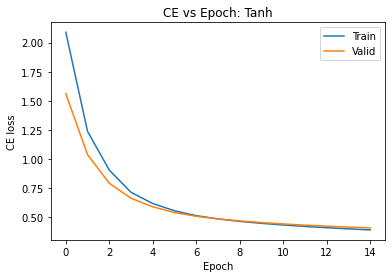

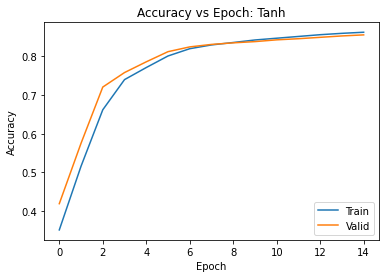

In [32]:
mlp_tanh = MLP(
    LinearLayer(28**2, HIDDEN_SIZE),
    tanhLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    tanhLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt_tanh = GradientDescentOptimizer(mlp_tanh, LEARNING_RATE)
mlp, losses_train, losses_valid, acc_train, acc_valid = mlp_tanh.fit(opt_tanh, x_train, y_train, x_valid, y_valid, steps = GRADIENT_STEPS, batch_size=BATCH_SIZE)

ce_vs_epoch(losses_train, losses_valid, "tanh", "Tanh")
acc_vs_epoch(acc_train, acc_valid, "tanh", "Tanh")

### Training Accuracy Tanh

In [33]:
predictions = mlp.predict(x_train)
acc = evaluate_acc(predictions, y_train)
print("Training Accuracy of 2 layer MLP Tanh: ", acc)


Training Accuracy of 2 layer MLP Tanh:  0.8648125


### Testing Accuracy Tanh

In [34]:
predictions = mlp.predict(x_test)
acc = evaluate_acc(predictions, y_test)
print("Test Accuracy of 2 layer MLP Tanh: ", acc)


Test Accuracy of 2 layer MLP Tanh:  0.845


### Check Gradient

In [35]:
grads = mlp.check_gradient(x_train, y_train)

Weight gradient difference: [4.996353700342495e-20, 4.9989461432961275e-20, 5.020972037570583e-20]
Biases gradient difference: [5.066256435363288e-17, 4.775142274055634e-17, 5.653412988910636e-17]


## Leaky-Relu

  7%|▋         | 1/15 [00:39<09:12, 39.47s/it]

iteration 0: train loss 2.2907746523294388, train acc 0.2583958333333335, valid loss 2.247494535875496, valid acc 0.3865 


 13%|█▎        | 2/15 [01:20<08:44, 40.36s/it]

iteration 1: train loss 1.8581194915411603, train acc 0.4206250000000001, valid loss 1.3668921524363107, valid acc 0.48891666666666667 


 20%|██        | 3/15 [02:00<08:00, 40.01s/it]

iteration 2: train loss 1.0500933227077043, train acc 0.5880833333333334, valid loss 0.8564285589301317, valid acc 0.7008333333333333 


 27%|██▋       | 4/15 [02:40<07:20, 40.02s/it]

iteration 3: train loss 0.735189849633635, train acc 0.7311250000000001, valid loss 0.6607157513188698, valid acc 0.7541666666666667 


 33%|███▎      | 5/15 [03:19<06:39, 39.93s/it]

iteration 4: train loss 0.611716513855437, train acc 0.76475, valid loss 0.5860939344950397, valid acc 0.7743333333333333 


 40%|████      | 6/15 [03:59<05:58, 39.88s/it]

iteration 5: train loss 0.5550772967283462, train acc 0.7827291666666658, valid loss 0.5453275771785141, valid acc 0.7889166666666667 


 47%|████▋     | 7/15 [04:39<05:18, 39.85s/it]

iteration 6: train loss 0.5190413122125307, train acc 0.8003750000000006, valid loss 0.5158417037352921, valid acc 0.8044166666666667 


 53%|█████▎    | 8/15 [05:20<04:41, 40.15s/it]

iteration 7: train loss 0.4908226713156, train acc 0.8174166666666666, valid loss 0.49064111269590654, valid acc 0.82025 


 60%|██████    | 9/15 [05:59<04:00, 40.01s/it]

iteration 8: train loss 0.46617601905228184, train acc 0.8298541666666667, valid loss 0.4687890975481973, valid acc 0.8313333333333334 


 67%|██████▋   | 10/15 [06:39<03:19, 39.92s/it]

iteration 9: train loss 0.4450186146376293, train acc 0.8384791666666666, valid loss 0.4504404105852173, valid acc 0.839 


 73%|███████▎  | 11/15 [07:19<02:39, 39.81s/it]

iteration 10: train loss 0.42698514790405995, train acc 0.8453124999999997, valid loss 0.4349771614024017, valid acc 0.8443333333333334 


 80%|████████  | 12/15 [07:59<01:59, 39.87s/it]

iteration 11: train loss 0.41140168695576007, train acc 0.8516666666666669, valid loss 0.42175031303482524, valid acc 0.8494166666666667 


 87%|████████▋ | 13/15 [08:38<01:19, 39.79s/it]

iteration 12: train loss 0.3978816792114825, train acc 0.8571875, valid loss 0.41062597408893586, valid acc 0.8525833333333334 


 93%|█████████▎| 14/15 [09:20<00:40, 40.26s/it]

iteration 13: train loss 0.3861718326583158, train acc 0.8604999999999998, valid loss 0.4013361077247802, valid acc 0.857 


100%|██████████| 15/15 [10:00<00:00, 40.05s/it]

iteration 14: train loss 0.37599378995369387, train acc 0.8643541666666669, valid loss 0.39350213008465745, valid acc 0.8605833333333334 


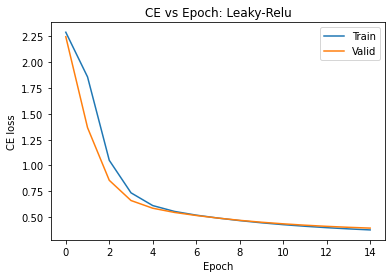

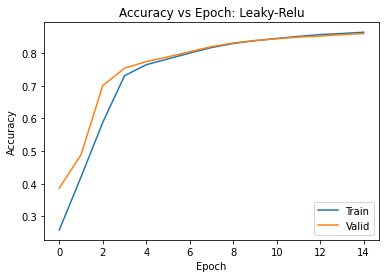

In [36]:
mlp_leaky = MLP(
    LinearLayer(28**2, HIDDEN_SIZE),
    LeakyReLULayer(slope = LEAKY_SLOPE),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLULayer(slope = LEAKY_SLOPE),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt_leaky = GradientDescentOptimizer(mlp_leaky, LEARNING_RATE)
mlp, losses_train, losses_valid, acc_train, acc_valid = mlp_leaky.fit(opt_leaky, x_train, y_train, 
                   x_valid, y_valid, steps = GRADIENT_STEPS, batch_size=BATCH_SIZE)

ce_vs_epoch(losses_train, losses_valid, "leaky_relu", "Leaky-Relu")
acc_vs_epoch(acc_train, acc_valid, "leaky_relu", "Leaky-Relu")

### Training Accuracy Leaky-Relu

In [37]:
predictions = mlp.predict(x_train)
acc = evaluate_acc(predictions, y_train)
print("Training Accuracy of 2 layer MLP Leaky: ", acc)


Training Accuracy of 2 layer MLP Leaky:  0.867875


### Testing Accuracy Leaky-Relu

In [38]:
predictions = mlp.predict(x_test)
acc = evaluate_acc(predictions, y_test)
print("Testing Accuracy of 2 layer MLP Leaky: ", acc)


Testing Accuracy of 2 layer MLP Leaky:  0.8488


### Check Gradient

In [39]:
grads = mlp.check_gradient(x_train, y_train)

Weight gradient difference: [5.013644895874122e-20, 4.9983156472541476e-20, 4.918602172886569e-20]
Biases gradient difference: [5.119179341043815e-17, 5.105322663626713e-17, 6.291499506716103e-17]


## Conclusions of different activation functions

From our tests, we can see that all three models actually give similar accuracies (approx. 86%) when trained with a good amount of epochs. However, the MLP with Relu activation still performed best compared to the MLP with tanh and leaky-rely activations. 

# Task 3.3 (L2-Regularization)

  7%|▋         | 1/15 [00:39<09:09, 39.25s/it]

iteration 0: train loss 2.2963827867520026, train acc 0.2325833333333333, valid loss 2.278689795396411, valid acc 0.36625 


 13%|█▎        | 2/15 [01:18<08:32, 39.40s/it]

iteration 1: train loss 1.9372033032200013, train acc 0.3158541666666667, valid loss 1.5164733248095048, valid acc 0.36841666666666667 


 20%|██        | 3/15 [02:01<08:10, 40.84s/it]

iteration 2: train loss 1.2108500721537754, train acc 0.5272708333333335, valid loss 0.921289981358323, valid acc 0.6731666666666667 


 27%|██▋       | 4/15 [02:43<07:36, 41.47s/it]

iteration 3: train loss 0.774956415735108, train acc 0.7136874999999996, valid loss 0.6910821018790795, valid acc 0.7408333333333333 


 33%|███▎      | 5/15 [03:26<06:59, 41.93s/it]

iteration 4: train loss 0.6364820696058175, train acc 0.7543124999999999, valid loss 0.6044001388905528, valid acc 0.7676666666666667 


 40%|████      | 6/15 [04:08<06:17, 41.94s/it]

iteration 5: train loss 0.5703418873703924, train acc 0.7777916666666663, valid loss 0.55427488376445, valid acc 0.7866666666666666 


 47%|████▋     | 7/15 [04:50<05:34, 41.81s/it]

iteration 6: train loss 0.5269916509794176, train acc 0.7979583333333341, valid loss 0.518376904099074, valid acc 0.8084166666666667 


 53%|█████▎    | 8/15 [05:31<04:52, 41.85s/it]

iteration 7: train loss 0.4933500492807041, train acc 0.8185000000000001, valid loss 0.48912227553869797, valid acc 0.82375 


 60%|██████    | 9/15 [06:12<04:09, 41.59s/it]

iteration 8: train loss 0.46613235160867084, train acc 0.8305208333333332, valid loss 0.46601515151017625, valid acc 0.83325 


 67%|██████▋   | 10/15 [06:55<03:29, 41.99s/it]

iteration 9: train loss 0.4444917775028167, train acc 0.8391458333333335, valid loss 0.4476913136173889, valid acc 0.8395 


 73%|███████▎  | 11/15 [07:38<02:48, 42.12s/it]

iteration 10: train loss 0.4264243868127594, train acc 0.845479166666667, valid loss 0.4324444006299256, valid acc 0.8436666666666667 


 80%|████████  | 12/15 [08:20<02:06, 42.14s/it]

iteration 11: train loss 0.4108513042086262, train acc 0.850791666666667, valid loss 0.4194695103797617, valid acc 0.8491666666666666 


 87%|████████▋ | 13/15 [09:02<01:23, 42.00s/it]

iteration 12: train loss 0.3974810966252665, train acc 0.8563125, valid loss 0.40861099112394134, valid acc 0.8524166666666667 


 93%|█████████▎| 14/15 [09:44<00:42, 42.18s/it]

iteration 13: train loss 0.38597793609856085, train acc 0.8602916666666671, valid loss 0.39955269069725213, valid acc 0.8571666666666666 


100%|██████████| 15/15 [10:26<00:00, 41.74s/it]

iteration 14: train loss 0.3759257271545215, train acc 0.8638333333333329, valid loss 0.39185794532598245, valid acc 0.8616666666666667 



  7%|▋         | 1/15 [00:44<10:16, 44.07s/it]

iteration 0: train loss 2.2951221901333385, train acc 0.19997916666666654, valid loss 2.273264502639639, valid acc 0.25116666666666665 


 13%|█▎        | 2/15 [01:26<09:18, 42.98s/it]

iteration 1: train loss 1.9294240182135922, train acc 0.37422916666666634, valid loss 1.4281162563144514, valid acc 0.4385 


 20%|██        | 3/15 [02:08<08:33, 42.83s/it]

iteration 2: train loss 1.1158854502540914, train acc 0.5395625000000004, valid loss 0.9373749668244288, valid acc 0.6315 


 27%|██▋       | 4/15 [02:54<08:00, 43.72s/it]

iteration 3: train loss 0.8177057539484925, train acc 0.6797499999999997, valid loss 0.7291985059701944, valid acc 0.73975 


 33%|███▎      | 5/15 [03:36<07:13, 43.40s/it]

iteration 4: train loss 0.656337174136758, train acc 0.7539583333333334, valid loss 0.610707508574875, valid acc 0.7674166666666666 


 40%|████      | 6/15 [04:20<06:31, 43.54s/it]

iteration 5: train loss 0.5776785590289818, train acc 0.7766041666666668, valid loss 0.5569594489673179, valid acc 0.786 


 47%|████▋     | 7/15 [05:04<05:49, 43.65s/it]

iteration 6: train loss 0.5322617480065424, train acc 0.7961458333333329, valid loss 0.5206188229300374, valid acc 0.8058333333333333 


 53%|█████▎    | 8/15 [05:48<05:05, 43.68s/it]

iteration 7: train loss 0.4981364920155674, train acc 0.8160416666666666, valid loss 0.49135121573958557, valid acc 0.8219166666666666 


 60%|██████    | 9/15 [06:30<04:19, 43.22s/it]

iteration 8: train loss 0.4699298426394947, train acc 0.8296666666666664, valid loss 0.46692772823393147, valid acc 0.83325 


 67%|██████▋   | 10/15 [07:13<03:36, 43.27s/it]

iteration 9: train loss 0.4465535793867278, train acc 0.8398749999999993, valid loss 0.4471812410533665, valid acc 0.8390833333333333 


 73%|███████▎  | 11/15 [07:55<02:51, 42.78s/it]

iteration 10: train loss 0.4272986860309509, train acc 0.8462500000000006, valid loss 0.43123251851893163, valid acc 0.8439166666666666 


 80%|████████  | 12/15 [08:38<02:08, 42.93s/it]

iteration 11: train loss 0.4111755570271674, train acc 0.8524166666666673, valid loss 0.4179843654269231, valid acc 0.849 


 87%|████████▋ | 13/15 [09:22<01:26, 43.02s/it]

iteration 12: train loss 0.397372584639164, train acc 0.8576041666666667, valid loss 0.4067164691184385, valid acc 0.85225 


 93%|█████████▎| 14/15 [10:05<00:43, 43.12s/it]

iteration 13: train loss 0.3855189108396594, train acc 0.8614374999999996, valid loss 0.39738912151463957, valid acc 0.8559166666666667 


100%|██████████| 15/15 [10:47<00:00, 43.19s/it]

iteration 14: train loss 0.3752316272008778, train acc 0.8650833333333333, valid loss 0.38955920088136026, valid acc 0.85775 



  7%|▋         | 1/15 [00:40<09:30, 40.73s/it]

iteration 0: train loss 2.2966467033560947, train acc 0.24318750000000017, valid loss 2.2829525886734, valid acc 0.41233333333333333 


 13%|█▎        | 2/15 [01:22<08:54, 41.10s/it]

iteration 1: train loss 1.955406859275828, train acc 0.3768124999999995, valid loss 1.3530602565145475, valid acc 0.42333333333333334 


 20%|██        | 3/15 [02:06<08:33, 42.78s/it]

iteration 2: train loss 1.0960257245103988, train acc 0.5578125, valid loss 0.9179236315599019, valid acc 0.6698333333333333 


 27%|██▋       | 4/15 [02:47<07:42, 42.05s/it]

iteration 3: train loss 0.785750137451128, train acc 0.7114999999999997, valid loss 0.6890458418752797, valid acc 0.751 


 33%|███▎      | 5/15 [03:27<06:52, 41.20s/it]

iteration 4: train loss 0.6297212745289343, train acc 0.7620208333333337, valid loss 0.5959254258536996, valid acc 0.773 


 40%|████      | 6/15 [04:07<06:07, 40.84s/it]

iteration 5: train loss 0.5635647696233603, train acc 0.7843958333333323, valid loss 0.5488484639657627, valid acc 0.79175 


 47%|████▋     | 7/15 [04:47<05:23, 40.43s/it]

iteration 6: train loss 0.5222001042496358, train acc 0.8039374999999999, valid loss 0.5150056596118048, valid acc 0.8105833333333333 


 53%|█████▎    | 8/15 [05:27<04:43, 40.45s/it]

iteration 7: train loss 0.49090404401057713, train acc 0.8202500000000003, valid loss 0.4877952310951474, valid acc 0.823 


 60%|██████    | 9/15 [06:09<04:04, 40.83s/it]

iteration 8: train loss 0.46561106042737005, train acc 0.8322083333333334, valid loss 0.4658170533799148, valid acc 0.8315833333333333 


 67%|██████▋   | 10/15 [06:51<03:26, 41.36s/it]

iteration 9: train loss 0.44488805260792513, train acc 0.8399999999999993, valid loss 0.447941372247978, valid acc 0.8375833333333333 


 73%|███████▎  | 11/15 [07:32<02:44, 41.06s/it]

iteration 10: train loss 0.4274796759724216, train acc 0.8460833333333334, valid loss 0.43297959259481156, valid acc 0.8431666666666666 


 80%|████████  | 12/15 [08:13<02:03, 41.15s/it]

iteration 11: train loss 0.41246787173446614, train acc 0.8514166666666669, valid loss 0.420369431120704, valid acc 0.84675 


 87%|████████▋ | 13/15 [08:53<01:21, 40.83s/it]

iteration 12: train loss 0.3992670381992171, train acc 0.8559583333333335, valid loss 0.40958113563527154, valid acc 0.8520833333333333 


 93%|█████████▎| 14/15 [09:34<00:40, 40.92s/it]

iteration 13: train loss 0.38771055829048257, train acc 0.86075, valid loss 0.4004580808291885, valid acc 0.8559166666666667 


100%|██████████| 15/15 [10:17<00:00, 41.15s/it]

iteration 14: train loss 0.37761094239814214, train acc 0.8635000000000003, valid loss 0.3927448242124571, valid acc 0.85925 



  7%|▋         | 1/15 [00:42<09:53, 42.36s/it]

iteration 0: train loss 2.298450605566624, train acc 0.23224999999999993, valid loss 2.28914856888096, valid acc 0.52025 


 13%|█▎        | 2/15 [01:23<09:03, 41.83s/it]

iteration 1: train loss 2.0490467745920617, train acc 0.4203541666666672, valid loss 1.5630873381083945, valid acc 0.4105 


 20%|██        | 3/15 [02:04<08:16, 41.36s/it]

iteration 2: train loss 1.1521981914256478, train acc 0.5499166666666675, valid loss 0.9041450412023466, valid acc 0.6719166666666667 


 27%|██▋       | 4/15 [02:45<07:33, 41.27s/it]

iteration 3: train loss 0.767940167246821, train acc 0.7109583333333337, valid loss 0.683765091455942, valid acc 0.7369166666666667 


 33%|███▎      | 5/15 [03:26<06:50, 41.06s/it]

iteration 4: train loss 0.6315270336619327, train acc 0.7509166666666663, valid loss 0.6043802252270706, valid acc 0.76525 


 40%|████      | 6/15 [04:10<06:17, 41.94s/it]

iteration 5: train loss 0.572281782800101, train acc 0.774499999999999, valid loss 0.5604665765720097, valid acc 0.7823333333333333 


 47%|████▋     | 7/15 [04:51<05:34, 41.83s/it]

iteration 6: train loss 0.5338888245172224, train acc 0.7904999999999996, valid loss 0.5290872232212485, valid acc 0.7950833333333334 


 53%|█████▎    | 8/15 [05:33<04:52, 41.77s/it]

iteration 7: train loss 0.504285938505104, train acc 0.8073541666666669, valid loss 0.5029217212965351, valid acc 0.8115833333333333 


 60%|██████    | 9/15 [06:14<04:09, 41.56s/it]

iteration 8: train loss 0.4784192009561987, train acc 0.8239166666666665, valid loss 0.4794293575773902, valid acc 0.82775 


 67%|██████▋   | 10/15 [06:55<03:27, 41.53s/it]

iteration 9: train loss 0.45552827459177253, train acc 0.8350208333333333, valid loss 0.45922389491606624, valid acc 0.8378333333333333 


 73%|███████▎  | 11/15 [07:36<02:45, 41.34s/it]

iteration 10: train loss 0.4361296310935608, train acc 0.8423958333333333, valid loss 0.44224057113045195, valid acc 0.8445 


 80%|████████  | 12/15 [08:21<02:06, 42.22s/it]

iteration 11: train loss 0.41946312973117283, train acc 0.8488333333333334, valid loss 0.42785272794968243, valid acc 0.84825 


 87%|████████▋ | 13/15 [09:01<01:23, 41.80s/it]

iteration 12: train loss 0.4047730085043587, train acc 0.8543958333333331, valid loss 0.415465617858191, valid acc 0.8521666666666666 


 93%|█████████▎| 14/15 [09:42<00:41, 41.54s/it]

iteration 13: train loss 0.39174445633641414, train acc 0.8592291666666662, valid loss 0.4047638741831676, valid acc 0.85475 


100%|██████████| 15/15 [10:23<00:00, 41.56s/it]

iteration 14: train loss 0.3802654614145783, train acc 0.8634166666666668, valid loss 0.395692259748294, valid acc 0.85975 



  7%|▋         | 1/15 [00:40<09:30, 40.78s/it]

iteration 0: train loss 2.2960979462351996, train acc 0.26266666666666677, valid loss 2.2784764547593523, valid acc 0.363 


 13%|█▎        | 2/15 [01:21<08:52, 40.99s/it]

iteration 1: train loss 1.925751157489289, train acc 0.3393749999999997, valid loss 1.4138972244465997, valid acc 0.40016666666666667 


 20%|██        | 3/15 [02:05<08:23, 41.99s/it]

iteration 2: train loss 1.122059694199109, train acc 0.5314166666666668, valid loss 0.9396497913670064, valid acc 0.62825 


 27%|██▋       | 4/15 [02:46<07:39, 41.75s/it]

iteration 3: train loss 0.806687311038987, train acc 0.6855208333333327, valid loss 0.7150941668888041, valid acc 0.7395833333333334 


 33%|███▎      | 5/15 [03:27<06:54, 41.49s/it]

iteration 4: train loss 0.6514989090510805, train acc 0.7486041666666662, valid loss 0.6141464011992228, valid acc 0.7641666666666667 


 40%|████      | 6/15 [04:09<06:14, 41.59s/it]

iteration 5: train loss 0.5792026297213083, train acc 0.7714166666666655, valid loss 0.5608186142285557, valid acc 0.7826666666666666 


 47%|████▋     | 7/15 [04:50<05:31, 41.44s/it]

iteration 6: train loss 0.5337194858967433, train acc 0.7903541666666657, valid loss 0.5245138593726726, valid acc 0.7981666666666667 


 53%|█████▎    | 8/15 [05:32<04:51, 41.67s/it]

iteration 7: train loss 0.5000327539650489, train acc 0.8108749999999992, valid loss 0.495612545184473, valid acc 0.8153333333333334 


 60%|██████    | 9/15 [06:16<04:14, 42.41s/it]

iteration 8: train loss 0.4713634032217829, train acc 0.8284166666666668, valid loss 0.47011492728354815, valid acc 0.8315 


 67%|██████▋   | 10/15 [06:59<03:32, 42.43s/it]

iteration 9: train loss 0.4462030534669105, train acc 0.8394583333333338, valid loss 0.44863901551907837, valid acc 0.84125 


 73%|███████▎  | 11/15 [07:41<02:49, 42.31s/it]

iteration 10: train loss 0.4252946827348387, train acc 0.8468333333333328, valid loss 0.4314893194671567, valid acc 0.8461666666666666 


 80%|████████  | 12/15 [08:23<02:06, 42.32s/it]

iteration 11: train loss 0.40854301758604034, train acc 0.8526041666666667, valid loss 0.4181054719055784, valid acc 0.8503333333333334 


 87%|████████▋ | 13/15 [09:05<01:24, 42.11s/it]

iteration 12: train loss 0.3950151583335415, train acc 0.8575416666666666, valid loss 0.4074750403180191, valid acc 0.8549166666666667 


 93%|█████████▎| 14/15 [09:47<00:42, 42.26s/it]

iteration 13: train loss 0.38375193592953677, train acc 0.8611874999999999, valid loss 0.398525362395177, valid acc 0.85775 


100%|██████████| 15/15 [10:32<00:00, 42.15s/it]

iteration 14: train loss 0.3740434150454047, train acc 0.8648750000000003, valid loss 0.39085544871005634, valid acc 0.8604166666666667 



  7%|▋         | 1/15 [00:41<09:40, 41.46s/it]

iteration 0: train loss 2.294546602633735, train acc 0.20193749999999994, valid loss 2.2696069080273826, valid acc 0.3481666666666667 


 13%|█▎        | 2/15 [01:23<09:02, 41.71s/it]

iteration 1: train loss 1.9374160422215385, train acc 0.3709374999999994, valid loss 1.5374531787642005, valid acc 0.41883333333333334 


 20%|██        | 3/15 [02:05<08:23, 41.95s/it]

iteration 2: train loss 1.1420917295506519, train acc 0.5237500000000009, valid loss 0.9288114536873786, valid acc 0.63 


 27%|██▋       | 4/15 [02:47<07:42, 42.09s/it]

iteration 3: train loss 0.7842129937251666, train acc 0.7004583333333324, valid loss 0.6907392667119332, valid acc 0.7445 


 33%|███▎      | 5/15 [03:28<06:54, 41.48s/it]

iteration 4: train loss 0.6360969789965033, train acc 0.752104166666666, valid loss 0.6049609132206856, valid acc 0.767 


 40%|████      | 6/15 [04:12<06:22, 42.50s/it]

iteration 5: train loss 0.5724513854387538, train acc 0.7745208333333328, valid loss 0.5567593100119539, valid acc 0.7833333333333333 


 47%|████▋     | 7/15 [04:53<05:34, 41.84s/it]

iteration 6: train loss 0.5302411565621419, train acc 0.7933750000000003, valid loss 0.5218236189303835, valid acc 0.7990833333333334 


 53%|█████▎    | 8/15 [05:34<04:51, 41.68s/it]

iteration 7: train loss 0.49744550785801545, train acc 0.8131875000000001, valid loss 0.493280898908297, valid acc 0.82075 


 60%|██████    | 9/15 [06:14<04:07, 41.28s/it]

iteration 8: train loss 0.46972052529046443, train acc 0.8296249999999998, valid loss 0.4690074525611892, valid acc 0.8321666666666667 


 67%|██████▋   | 10/15 [06:55<03:25, 41.19s/it]

iteration 9: train loss 0.4462955105372801, train acc 0.8390208333333342, valid loss 0.4490134799205913, valid acc 0.8404166666666667 


 73%|███████▎  | 11/15 [07:36<02:44, 41.01s/it]

iteration 10: train loss 0.4267969757678565, train acc 0.8461666666666672, valid loss 0.4326659269584775, valid acc 0.8458333333333333 


 80%|████████  | 12/15 [08:17<02:03, 41.03s/it]

iteration 11: train loss 0.4104511863521299, train acc 0.852041666666667, valid loss 0.41919934257004265, valid acc 0.84925 


 87%|████████▋ | 13/15 [08:57<01:21, 40.81s/it]

iteration 12: train loss 0.39658445563725714, train acc 0.856791666666667, valid loss 0.40800667009715047, valid acc 0.8545 


 93%|█████████▎| 14/15 [09:40<00:41, 41.29s/it]

iteration 13: train loss 0.3847471423500169, train acc 0.8611041666666669, valid loss 0.39870657275723115, valid acc 0.8584166666666667 


100%|██████████| 15/15 [10:23<00:00, 41.59s/it]

iteration 14: train loss 0.37444347183266197, train acc 0.8646458333333334, valid loss 0.39078748221243614, valid acc 0.8620833333333333 


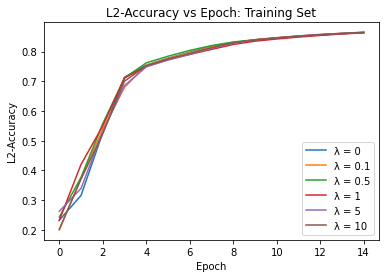

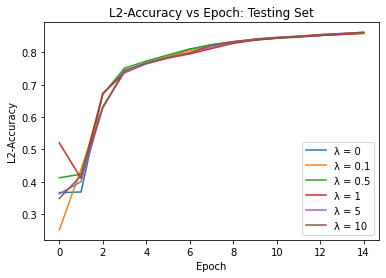

In [40]:
lambdas = [0, 0.1, 0.5, 1, 5, 10]
l2_train_acc = []
l2_test_acc = []

for l in lambdas:
    mlp_l2 = MLP(
        LinearLayer(28**2, HIDDEN_SIZE),
        ReLULayer(),
        LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
        ReLULayer(),
        LinearLayer(HIDDEN_SIZE, 10),
        SoftmaxOutputLayer()
    )
    opt_l2 = GradientDescentOptimizer(mlp_l2, LEARNING_RATE)

    mlp_l2, losses_train, losses_valid, acc_train, acc_valid = mlp_l2.fit(opt_l2, x_train, y_train, x_valid, y_valid, alpha=l, l2=True, steps = GRADIENT_STEPS, batch_size = BATCH_SIZE)

    # Training acc
    predictions = mlp_l2.predict(x_train, testing=True)
    l2_train_acc.append(acc_train)

    # Testing acc
    predictions = mlp_l2.predict(x_test, testing=True)
    l2_test_acc.append(acc_valid)


# Plot training accuracy over different lambdas
plt.clf()
plt.plot(l2_train_acc[0], label = "λ = 0")
plt.plot(l2_train_acc[1], label = "λ = 0.1")
plt.plot(l2_train_acc[2], label = "λ = 0.5")
plt.plot(l2_train_acc[3], label = "λ = 1")
plt.plot(l2_train_acc[4], label = "λ = 5")
plt.plot(l2_train_acc[5], label = "λ = 10")
plt.xlabel("Epoch")
plt.ylabel("L2-Accuracy")
plt.legend(loc='lower right')
plt.title(f"L2-Accuracy vs Epoch: Training Set")
plt.savefig(f"training_vs_valid_acc_diff_lambdas_train.png", bbox_inches="tight", dpi=300)
plt.show()

# Plot testing accuracy over different lambdas
plt.clf()
plt.plot(l2_test_acc[0], label = "λ = 0")
plt.plot(l2_test_acc[1], label = "λ = 0.1")
plt.plot(l2_test_acc[2], label = "λ = 0.5")
plt.plot(l2_test_acc[3], label = "λ = 1")
plt.plot(l2_test_acc[4], label = "λ = 5")
plt.plot(l2_test_acc[5], label = "λ = 10")
plt.xlabel("Epoch")
plt.ylabel("L2-Accuracy")
plt.legend(loc='lower right')
plt.title(f"L2-Accuracy vs Epoch: Testing Set")
plt.savefig(f"training_vs_valid_acc_diff_lambdas_test.png", bbox_inches="tight", dpi=300)
plt.show()

# Task 3.4

In [41]:
print(x_train_u.shape)
print(x_train.shape)

(48000, 784)
(48000, 784)


In [42]:
mlp_unnormalized = MLP(LinearLayer(28**2, HIDDEN_SIZE),
                       ReLULayer(),
                       LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
                       ReLULayer(),
                       LinearLayer(HIDDEN_SIZE, 10),
                       SoftmaxOutputLayer())
opt_unnormalized = GradientDescentOptimizer(mlp_unnormalized, LEARNING_RATE)



In [43]:
mlp = mlp_unnormalized.fit(opt_unnormalized, x_train_u, y_train_u, x_valid_u, y_valid_u, steps = GRADIENT_STEPS, batch_size = BATCH_SIZE)[0]

  7%|▋         | 1/15 [00:42<09:54, 42.48s/it]

iteration 0: train loss 0.6747402145768351, train acc 0.7508333333333324, valid loss 0.45067496650803307, valid acc 0.8301666666666667 


 13%|█▎        | 2/15 [01:24<09:09, 42.28s/it]

iteration 1: train loss 0.43794607083146914, train acc 0.838854166666667, valid loss 0.4044521134363976, valid acc 0.8538333333333333 


 20%|██        | 3/15 [02:06<08:27, 42.26s/it]

iteration 2: train loss 0.3878353758108791, train acc 0.8583125000000009, valid loss 0.3790845403241145, valid acc 0.86025 


 27%|██▋       | 4/15 [02:49<07:44, 42.27s/it]

iteration 3: train loss 0.35450870614472174, train acc 0.8697083333333331, valid loss 0.37038061009329926, valid acc 0.8646666666666667 


 33%|███▎      | 5/15 [03:31<07:03, 42.36s/it]

iteration 4: train loss 0.3336141450322258, train acc 0.8760624999999995, valid loss 0.36243686504013417, valid acc 0.8674166666666666 


 40%|████      | 6/15 [04:14<06:22, 42.49s/it]

iteration 5: train loss 0.31524108180289867, train acc 0.8829791666666675, valid loss 0.3503646371717714, valid acc 0.8724166666666666 


 47%|████▋     | 7/15 [04:56<05:39, 42.43s/it]

iteration 6: train loss 0.29693115762679506, train acc 0.8885833333333343, valid loss 0.3490932556538893, valid acc 0.87425 


 53%|█████▎    | 8/15 [05:41<05:03, 43.31s/it]

iteration 7: train loss 0.2962141488229077, train acc 0.890062500000001, valid loss 0.33998264659203853, valid acc 0.8783333333333333 


 60%|██████    | 9/15 [06:24<04:18, 43.02s/it]

iteration 8: train loss 0.2748008501763885, train acc 0.8962916666666672, valid loss 0.3378342304893597, valid acc 0.8805833333333334 


 67%|██████▋   | 10/15 [07:06<03:33, 42.74s/it]

iteration 9: train loss 0.2615799847900385, train acc 0.9016875000000011, valid loss 0.3509027839312433, valid acc 0.875 


 73%|███████▎  | 11/15 [07:48<02:50, 42.58s/it]

iteration 10: train loss 0.25353660125455507, train acc 0.9037916666666674, valid loss 0.3494243584718221, valid acc 0.8785 


 80%|████████  | 12/15 [08:30<02:06, 42.32s/it]

iteration 11: train loss 0.24532033638717218, train acc 0.9078124999999998, valid loss 0.3468367504662781, valid acc 0.8800833333333333 


 87%|████████▋ | 13/15 [09:12<01:24, 42.17s/it]

iteration 12: train loss 0.24516625398529815, train acc 0.9077708333333341, valid loss 0.35752120062032083, valid acc 0.8796666666666667 


 93%|█████████▎| 14/15 [09:54<00:42, 42.13s/it]

iteration 13: train loss 0.24592197330334306, train acc 0.9095208333333338, valid loss 0.3501885705599055, valid acc 0.88025 


100%|██████████| 15/15 [10:36<00:00, 42.44s/it]

iteration 14: train loss 0.22990330632828748, train acc 0.9132083333333336, valid loss 0.37272728802988453, valid acc 0.8778333333333334 


## Training Accuracy Unnormalized

In [44]:
predictions = mlp.predict(x_train_u, testing=True)
acc = evaluate_acc(predictions, y_train_u)
print("Training Accuracy with 2 layer MLP Unnormalized: ", acc)

Training Accuracy with 2 layer MLP Unnormalized:  0.9018125


## Testing Accuracy Unnormalized

In [45]:
predictions = mlp.predict(x_test_unnormalized, testing=True)
acc = evaluate_acc(predictions, y_test)
print("Testing Accuracy with 2 layer MLP Unnormalized: ", acc)

Testing Accuracy with 2 layer MLP Unnormalized:  0.8711


### Check Gradient

In [46]:
grads = mlp.check_gradient(x_train, y_train)

Weight gradient difference: [5.0110003936269144e-20, 4.98593812550071e-20, 5.011089778937842e-20]
Biases gradient difference: [4.9292962007322424e-17, 5.1052021518304005e-17, 3.4752961959152767e-17]


## Conclusions Normalized vs Unnormalized

From our tests, it seems like normalizing the dataset does not provide a greater testing accuracy compared to the model trained with unnormalized data. However, this is mainly a result of a very small variance when initializing the weights and biaises in the LinearLayer. 

# Task 3.5

## Convolutional Neural Network

In [47]:
# Base model ( overfits )
model = Sequential()
model.add(layers.Conv2D(16, kernel_size=(3,3), 
                        activation="relu", 
                        input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, 
                        kernel_size=(3,3), 
                        activation="relu",
                        ))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [48]:
print(x_train.reshape(x_train.shape[0], 28, 28, 1).shape)

(48000, 28, 28, 1)


Epoch 1/15
1500/1500 [==============================] - 35s 23ms/step - loss: 0.4969 - accuracy: 0.8180 - val_loss: 0.3924 - val_accuracy: 0.8574
Epoch 2/15
1500/1500 [==============================] - 31s 20ms/step - loss: 0.3434 - accuracy: 0.8739 - val_loss: 0.3609 - val_accuracy: 0.8667
Epoch 3/15
1500/1500 [==============================] - 31s 21ms/step - loss: 0.3007 - accuracy: 0.8890 - val_loss: 0.3432 - val_accuracy: 0.8741
Epoch 4/15
1500/1500 [==============================] - 29s 19ms/step - loss: 0.2689 - accuracy: 0.9006 - val_loss: 0.3391 - val_accuracy: 0.8768
Epoch 5/15
1500/1500 [==============================] - 31s 21ms/step - loss: 0.2471 - accuracy: 0.9080 - val_loss: 0.3211 - val_accuracy: 0.8867
Epoch 6/15
1500/1500 [==============================] - 31s 21ms/step - loss: 0.2236 - accuracy: 0.9149 - val_loss: 0.3140 - val_accuracy: 0.8903
Epoch 7/15
1500/1500 [==============================] - 31s 20ms/step - loss: 0.2067 - accuracy: 0.9208 - val_loss: 0.3037 -

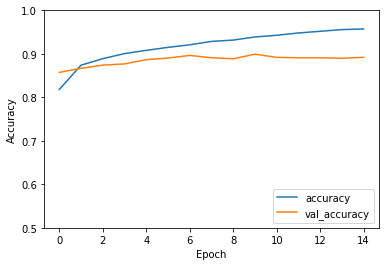

In [49]:
num_epoch = 15
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
trained = model.fit(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train_conv, epochs=num_epoch, 
                    validation_data = (x_test.reshape(x_test.shape[0], 28, 28, 1), y_test_conv))

plt.plot(trained.history['accuracy'], label='accuracy')
plt.plot(trained.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [50]:
# score = model.evaluate(x_test.reshape(x_test.shape[0], 28, 28, 1), y_test, verbose=False) #returns list
# print("Trained with {} epochs: ".format(num_epoch))
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

### Fitting hyperparameters

#### Kernal size

In [51]:
N = 4
models = [0] * N
print(models)
for model_num in range(N):
  models[model_num] = Sequential()
  models[model_num].add(layers.Conv2D(16, kernel_size=(model_num+2,model_num+2), 
                        activation="relu", input_shape=(28, 28, 1)))
  models[model_num].add(layers.MaxPooling2D((2,2)))
  models[model_num].add(layers.Conv2D(16, 
                        kernel_size=(model_num+2,model_num+2), 
                        activation="relu",
                        ))
  models[model_num].add(layers.MaxPooling2D(pool_size=(2, 2)))
  models[model_num].add(Flatten())
  models[model_num].add(Dense(128, activation="relu"))
  models[model_num].add(Dense(128, activation="relu"))
  models[model_num].add(Dense(10, activation="softmax"))
  models[model_num].summary()


[0, 0, 0, 0]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 27, 27, 16)        80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 16)        1040      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 576)               0         
                                                                 
 dense_6 (Dense)             (None, 128) 

Epoch 1/15
1500/1500 [==============================] - 29s 19ms/step - loss: 0.4650 - accuracy: 0.8335 - val_loss: 0.3622 - val_accuracy: 0.8684
Epoch 2/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3171 - accuracy: 0.8833 - val_loss: 0.3444 - val_accuracy: 0.8786
Epoch 3/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2766 - accuracy: 0.8983 - val_loss: 0.3171 - val_accuracy: 0.8847
Epoch 4/15
1500/1500 [==============================] - 28s 18ms/step - loss: 0.2482 - accuracy: 0.9070 - val_loss: 0.3130 - val_accuracy: 0.8891
Epoch 5/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2266 - accuracy: 0.9154 - val_loss: 0.3189 - val_accuracy: 0.8847
Epoch 6/15
1500/1500 [==============================] - 28s 19ms/step - loss: 0.2044 - accuracy: 0.9229 - val_loss: 0.3371 - val_accuracy: 0.8816
Epoch 7/15
1500/1500 [==============================] - 28s 19ms/step - loss: 0.1891 - accuracy: 0.9283 - val_loss: 0.3040 -

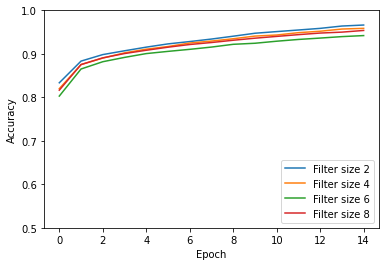

In [52]:
num_epoch = 15
filter_size = 0
for model in models:
  model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
  trained = model.fit(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train_conv, epochs=num_epoch, 
                    validation_data = (x_test.reshape(x_test.shape[0], 28, 28, 1), y_test_conv))

  filter_size += 2
  plt.plot(trained.history['accuracy'], label="Filter size " + str(filter_size))
  #plt.plot(trained.history['val_accuracy'], label = "Filter_size " + str(filter_size))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

#### Stride length

In [53]:
N = 4
models = [0] * N
for model_num in range(N):
  models[model_num] = Sequential()
  models[model_num].add(layers.Conv2D(16, kernel_size=(2,2), activation="relu", input_shape=(28, 28, 1), 
                                      strides = (model_num +1 , model_num +1),  padding = 'same'))
  models[model_num].add(layers.MaxPooling2D((2,2),padding='same'))
  models[model_num].add(layers.Conv2D(16, kernel_size=(2,2), activation="relu", 
                                      strides = (model_num + 1, model_num + 1), padding = 'same'))
  models[model_num].add(layers.MaxPooling2D(pool_size=(2, 2),padding='same'))
  models[model_num].add(Flatten())
  models[model_num].add(Dense(128, activation="relu"))
  models[model_num].add(Dense(128, activation="relu"))
  models[model_num].add(Dense(10, activation="softmax"))
  models[model_num].summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 16)        80        
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 16)        1040      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)              

Epoch 1/15
1500/1500 [==============================] - 33s 21ms/step - loss: 0.4556 - accuracy: 0.8344 - val_loss: 0.3726 - val_accuracy: 0.8697
Epoch 2/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.3124 - accuracy: 0.8853 - val_loss: 0.3312 - val_accuracy: 0.8813
Epoch 3/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2678 - accuracy: 0.9003 - val_loss: 0.3306 - val_accuracy: 0.8795
Epoch 4/15
1500/1500 [==============================] - 33s 22ms/step - loss: 0.2407 - accuracy: 0.9107 - val_loss: 0.3232 - val_accuracy: 0.8873
Epoch 5/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2147 - accuracy: 0.9203 - val_loss: 0.3264 - val_accuracy: 0.8869
Epoch 6/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.1970 - accuracy: 0.9257 - val_loss: 0.3196 - val_accuracy: 0.8882
Epoch 7/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.1768 - accuracy: 0.9343 - val_loss: 0.3029 -

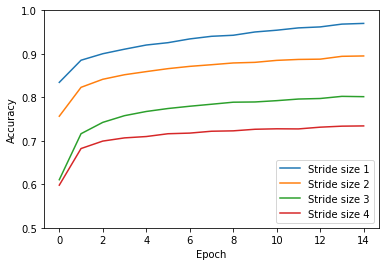

In [54]:
num_epoch = 15
stride_size = 0
for model in models:
  model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
  trained = model.fit(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train_conv, epochs=num_epoch, 
                    validation_data = (x_test.reshape(x_test.shape[0], 28, 28, 1), y_test_conv))

  stride_size += 1
  plt.plot(trained.history['accuracy'], label="Stride size " + str(stride_size))
  #plt.plot(trained.history['val_accuracy'], label = "Stride size " + str(stride_size))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

#### Max pooling window size

In [55]:
N = 4
models = [0] * N
for model_num in range(N):
  models[model_num] = Sequential()
  models[model_num].add(layers.Conv2D(16, kernel_size=(2,2), activation="relu", input_shape=(28, 28, 1), 
                                      strides = (1,1),  padding = 'same'))
  models[model_num].add(layers.MaxPooling2D((model_num + 2, model_num + 2)))
  models[model_num].add(layers.Conv2D(16, kernel_size=(2,2), activation="relu", 
                                      strides = (1,1), padding = 'same'))
  models[model_num].add(layers.MaxPooling2D(pool_size=(model_num + 2, model_num + 2), strides = (1,1)))
  models[model_num].add(Flatten())
  models[model_num].add(Dense(128, activation="relu"))
  models[model_num].add(Dense(128, activation="relu"))
  models[model_num].add(Dense(10, activation="softmax"))
  models[model_num].summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 16)        80        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 16)        1040      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 2704)              0         
                                                                 
 dense_30 (Dense)            (None, 128)             

Epoch 1/2
1500/1500 [==============================] - 38s 25ms/step - loss: 0.4169 - accuracy: 0.8479 - val_loss: 0.3400 - val_accuracy: 0.8754
Epoch 2/2
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2863 - accuracy: 0.8948 - val_loss: 0.3175 - val_accuracy: 0.8845
Epoch 1/2
1500/1500 [==============================] - 28s 18ms/step - loss: 0.5417 - accuracy: 0.7996 - val_loss: 0.4529 - val_accuracy: 0.8364
Epoch 2/2
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3755 - accuracy: 0.8622 - val_loss: 0.3641 - val_accuracy: 0.8689
Epoch 1/2
1500/1500 [==============================] - 25s 16ms/step - loss: 0.6755 - accuracy: 0.7506 - val_loss: 0.5600 - val_accuracy: 0.7896
Epoch 2/2
1500/1500 [==============================] - 23s 15ms/step - loss: 0.4723 - accuracy: 0.8271 - val_loss: 0.4384 - val_accuracy: 0.8416
Epoch 1/2
1500/1500 [==============================] - 21s 14ms/step - loss: 0.8265 - accuracy: 0.6875 - val_loss: 0.6477 - val_ac

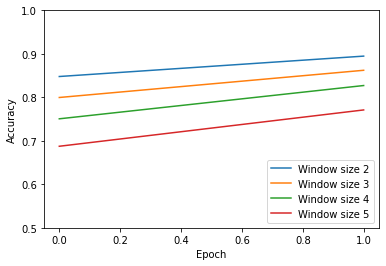

In [56]:
num_epoch = 2
pooling_window_size = 1
for model in models:
  model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
  trained = model.fit(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train_conv, epochs=num_epoch, 
                    validation_data = (x_test.reshape(x_test.shape[0], 28, 28, 1), y_test_conv))

  pooling_window_size += 1
  plt.plot(trained.history['accuracy'], label="Window size " + str(pooling_window_size))
  #plt.plot(trained.history['val_accuracy'], label = "Window size " + str(pooling_window_size))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')

### Dropout models and fitting dropout rate

In [57]:
# Model 1 ( only apply small dropout on the convolution layers )
dropout_rate = [0, 0.0625, 0.125, 0.1875, 0.25]
N = 5
models = [0] * 5
for i in range(len(models)):
  model = Sequential()
  model.add(layers.Conv2D(16, kernel_size=(3,3), 
                        activation="relu", 
                        input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Dropout(dropout_rate[i]))
  model.add(layers.Conv2D(16, 
                        kernel_size=(3,3), 
                        activation="relu",
                        ))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(dropout_rate[i]))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dense(128, activation="relu"))
  model.add(Dense(10, activation="softmax"))
  #model.summary()
  models[i] = model

Epoch 1/15
1500/1500 [==============================] - 33s 21ms/step - loss: 0.5151 - accuracy: 0.8102 - val_loss: 0.4159 - val_accuracy: 0.8490
Epoch 2/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.3445 - accuracy: 0.8722 - val_loss: 0.3554 - val_accuracy: 0.8679
Epoch 3/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2978 - accuracy: 0.8893 - val_loss: 0.3264 - val_accuracy: 0.8788
Epoch 4/15
1500/1500 [==============================] - 31s 21ms/step - loss: 0.2688 - accuracy: 0.8999 - val_loss: 0.3252 - val_accuracy: 0.8858
Epoch 5/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2456 - accuracy: 0.9071 - val_loss: 0.3214 - val_accuracy: 0.8843
Epoch 6/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2251 - accuracy: 0.9147 - val_loss: 0.3051 - val_accuracy: 0.8916
Epoch 7/15
1500/1500 [==============================] - 32s 21ms/step - loss: 0.2096 - accuracy: 0.9213 - val_loss: 0.3159 -

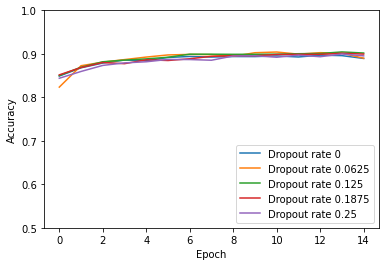

In [58]:
num_epoch = 15
drop_rate = 0
for model in models:
  model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
  trained = model.fit(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train_conv, epochs=num_epoch, 
                    validation_data = (x_test.reshape(x_test.shape[0], 28, 28, 1), y_test_conv))

  #plt.plot(trained.history['accuracy'], label="Dropout rate " + str(drop_rate))
  plt.plot(trained.history['val_accuracy'], label = "Dropout rate " + str(drop_rate))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')
  drop_rate += 0.0625

In [59]:
# Model 2 ( only apply dropout on the dense layers )
dropout_rate = [0, 0.25, 0.5]
N = 3
models = [0] * 3
for i in range(len(models)):
  model = Sequential()
  model.add(layers.Conv2D(16, kernel_size=(3,3), 
                        activation="relu", 
                        input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(16, 
                        kernel_size=(3,3), 
                        activation="relu",
                        ))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(layers.Dropout(dropout_rate[i]))
  model.add(Dense(128, activation="relu"))
  model.add(layers.Dropout(dropout_rate[i]))
  model.add(Dense(10, activation="softmax"))
  #model.summary()
  models[i] = model

Epoch 1/2
1500/1500 [==============================] - 30s 19ms/step - loss: 0.4944 - accuracy: 0.8185 - val_loss: 0.3809 - val_accuracy: 0.8623
Epoch 2/2
1500/1500 [==============================] - 29s 19ms/step - loss: 0.3373 - accuracy: 0.8767 - val_loss: 0.3532 - val_accuracy: 0.8674
Epoch 1/2
1500/1500 [==============================] - 29s 19ms/step - loss: 0.5893 - accuracy: 0.7873 - val_loss: 0.4207 - val_accuracy: 0.8451
Epoch 2/2
1500/1500 [==============================] - 29s 19ms/step - loss: 0.3958 - accuracy: 0.8570 - val_loss: 0.3539 - val_accuracy: 0.8706
Epoch 1/2
1500/1500 [==============================] - 30s 19ms/step - loss: 0.7308 - accuracy: 0.7303 - val_loss: 0.4666 - val_accuracy: 0.8209
Epoch 2/2
1500/1500 [==============================] - 28s 19ms/step - loss: 0.4961 - accuracy: 0.8173 - val_loss: 0.4086 - val_accuracy: 0.8503


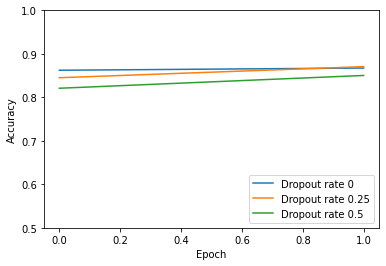

In [60]:
num_epoch = 2
drop_rate = 0
for model in models:
  model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
  trained = model.fit(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train_conv, epochs=num_epoch, 
                    validation_data = (x_test.reshape(x_test.shape[0], 28, 28, 1), y_test_conv))

  #plt.plot(trained.history['accuracy'], label="Dropout rate " + str(drop_rate))
  plt.plot(trained.history['val_accuracy'], label = "Dropout rate " + str(drop_rate))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')
  drop_rate += 0.25

In [61]:
# Mix of model 1 and model 2
dropout_rate_conv = [0, 0.10, 0.2]
dropout_rate_dense = [0, 0.25, 0.5]
N = 3
models = [0] * 3
for i in range(len(models)):
  model = Sequential()
  model.add(layers.Conv2D(16, kernel_size=(3,3), 
                        activation="relu", 
                        input_shape=(28, 28, 1)))
 #model.add(layers.Dropout(dropout_rate_conv[i]))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Dropout(dropout_rate_conv[i]))
  model.add(layers.Conv2D(16, 
                        kernel_size=(3,3), 
                        activation="relu",
                        ))
 #model.add(layers.Dropout(dropout_rate_conv[i]))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(dropout_rate_conv[i]))
  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(layers.Dropout(dropout_rate_dense[i]))
  model.add(Dense(128, activation="relu"))
  model.add(layers.Dropout(dropout_rate_dense[i]))
  model.add(Dense(10, activation="softmax"))
  #model.summary()
  models[i] = model

Epoch 1/15
1500/1500 [==============================] - 29s 19ms/step - loss: 0.4878 - accuracy: 0.8228 - val_loss: 0.3972 - val_accuracy: 0.8559
Epoch 2/15
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3331 - accuracy: 0.8783 - val_loss: 0.3362 - val_accuracy: 0.8738
Epoch 3/15
1500/1500 [==============================] - 31s 20ms/step - loss: 0.2904 - accuracy: 0.8932 - val_loss: 0.3185 - val_accuracy: 0.8835
Epoch 4/15
1500/1500 [==============================] - 28s 18ms/step - loss: 0.2622 - accuracy: 0.9024 - val_loss: 0.3192 - val_accuracy: 0.8851
Epoch 5/15
1500/1500 [==============================] - 28s 18ms/step - loss: 0.2399 - accuracy: 0.9098 - val_loss: 0.3044 - val_accuracy: 0.8931
Epoch 6/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2205 - accuracy: 0.9173 - val_loss: 0.2932 - val_accuracy: 0.8936
Epoch 7/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2020 - accuracy: 0.9241 - val_loss: 0.3011 -

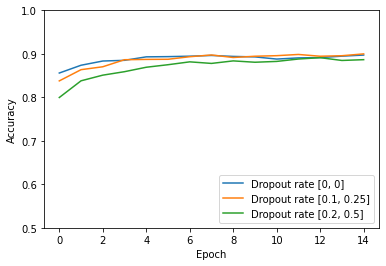

In [62]:
num_epoch = 15
drop_rate = [0,0]
for model in models:
  model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
  trained = model.fit(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train_conv, epochs=num_epoch, 
                    validation_data = (x_test.reshape(x_test.shape[0], 28, 28, 1), y_test_conv))

  #plt.plot(trained.history['accuracy'], label="Dropout rate " + str(drop_rate))
  plt.plot(trained.history['val_accuracy'], label = "Dropout rate " + str(drop_rate))
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='lower right')
  drop_rate[0] += 0.1
  drop_rate[1] += 0.25

### Best Convolutional Model

In [63]:
model = Sequential()
model.add(layers.Conv2D(16, kernel_size=(2,2), activation="relu", input_shape=(28, 28, 1), 
                        strides = (1,1),  padding = 'same'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, kernel_size=(2,2), activation="relu",
                        strides = (1,1),  padding = 'same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(layers.Dropout(0.25))
model.add(Dense(128, activation="relu"))
model.add(layers.Dropout(0.25))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 28, 28, 16)        80        
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 14, 14, 16)        1040      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 7, 7, 16)         0         
 g2D)                                                            
                                                                 
 flatten_25 (Flatten)        (None, 784)               0         
                                                                 
 dense_75 (Dense)            (None, 128)             

Epoch 1/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.5222 - accuracy: 0.8105 - val_loss: 0.3577 - val_accuracy: 0.8680
Epoch 2/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3514 - accuracy: 0.8727 - val_loss: 0.3186 - val_accuracy: 0.8870
Epoch 3/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.3073 - accuracy: 0.8892 - val_loss: 0.3039 - val_accuracy: 0.8904
Epoch 4/15
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2820 - accuracy: 0.8971 - val_loss: 0.3004 - val_accuracy: 0.8900
Epoch 5/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.2607 - accuracy: 0.9040 - val_loss: 0.2872 - val_accuracy: 0.8963
Epoch 6/15
1500/1500 [==============================] - 26s 17ms/step - loss: 0.2439 - accuracy: 0.9096 - val_loss: 0.2813 - val_accuracy: 0.9015
Epoch 7/15
1500/1500 [==============================] - 26s 18ms/step - loss: 0.2293 - accuracy: 0.9153 - val_loss: 0.2832 -

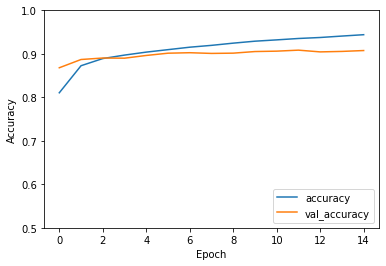

In [64]:
num_epoch = 15
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
trained = model.fit(x_train.reshape(x_train.shape[0], 28, 28, 1), y_train_conv, epochs=num_epoch, 
                    validation_data = (x_test.reshape(x_test.shape[0], 28, 28, 1), y_test_conv))

plt.plot(trained.history['accuracy'], label='accuracy')
plt.plot(trained.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Task 3.6

## Increasing the amount of hidden layers (3 layers)

  7%|▋         | 1/15 [00:48<11:16, 48.29s/it]

iteration 0: train loss 0.794594941020179, train acc 0.7233541666666657, valid loss 0.5752823134464957, valid acc 0.7906666666666666 


 13%|█▎        | 2/15 [01:34<10:15, 47.35s/it]

iteration 1: train loss 0.5293272076746505, train acc 0.8077708333333328, valid loss 0.49874799772358624, valid acc 0.8181666666666667 


 20%|██        | 3/15 [02:24<09:41, 48.45s/it]

iteration 2: train loss 0.46995062733597254, train acc 0.8298125000000005, valid loss 0.4627695245151098, valid acc 0.8334166666666667 


 27%|██▋       | 4/15 [03:12<08:50, 48.23s/it]

iteration 3: train loss 0.4353502482580184, train acc 0.8418541666666665, valid loss 0.4406600053502607, valid acc 0.8396666666666667 


 33%|███▎      | 5/15 [04:00<08:00, 48.04s/it]

iteration 4: train loss 0.41104539444298543, train acc 0.8501875000000002, valid loss 0.42490481744709335, valid acc 0.8455833333333334 


 40%|████      | 6/15 [04:46<07:07, 47.46s/it]

iteration 5: train loss 0.39234464287465987, train acc 0.857083333333334, valid loss 0.4132594743771084, valid acc 0.8510833333333333 


 47%|████▋     | 7/15 [05:34<06:19, 47.43s/it]

iteration 6: train loss 0.3770309953513328, train acc 0.8627083333333343, valid loss 0.4043501114678961, valid acc 0.8555 


 53%|█████▎    | 8/15 [06:22<05:33, 47.60s/it]

iteration 7: train loss 0.3641329106231179, train acc 0.8680000000000001, valid loss 0.3970110769878414, valid acc 0.8586666666666667 


 60%|██████    | 9/15 [07:11<04:49, 48.28s/it]

iteration 8: train loss 0.3529723720711534, train acc 0.8716666666666671, valid loss 0.39078707660246803, valid acc 0.8601666666666666 


 67%|██████▋   | 10/15 [07:58<03:59, 47.85s/it]

iteration 9: train loss 0.3430179515003929, train acc 0.8756875000000004, valid loss 0.3854915904136977, valid acc 0.8625 


 73%|███████▎  | 11/15 [08:45<03:10, 47.59s/it]

iteration 10: train loss 0.3340452619989029, train acc 0.8790833333333334, valid loss 0.3811164173358922, valid acc 0.8645833333333334 


 80%|████████  | 12/15 [09:33<02:23, 47.69s/it]

iteration 11: train loss 0.3258393205756454, train acc 0.8820624999999992, valid loss 0.37746708876212, valid acc 0.8661666666666666 


 87%|████████▋ | 13/15 [10:20<01:35, 47.59s/it]

iteration 12: train loss 0.31823421844986605, train acc 0.8850624999999991, valid loss 0.37407414894562985, valid acc 0.8678333333333333 


 93%|█████████▎| 14/15 [11:08<00:47, 47.67s/it]

iteration 13: train loss 0.31121112555248576, train acc 0.8876666666666662, valid loss 0.37109866797265406, valid acc 0.8686666666666667 


100%|██████████| 15/15 [11:58<00:00, 47.91s/it]


iteration 14: train loss 0.3046118357703795, train acc 0.8898749999999996, valid loss 0.36855546562177083, valid acc 0.8703333333333333 
Weight gradient difference: []
Biases gradient difference: []


  7%|▋         | 1/15 [00:53<12:27, 53.42s/it]

iteration 0: train loss 0.8281190343370368, train acc 0.7101458333333333, valid loss 0.5735488888307804, valid acc 0.7920833333333334 


 13%|█▎        | 2/15 [01:46<11:29, 53.03s/it]

iteration 1: train loss 0.5296861608570108, train acc 0.8056875000000002, valid loss 0.4943527964213015, valid acc 0.8203333333333334 


 20%|██        | 3/15 [02:38<10:31, 52.62s/it]

iteration 2: train loss 0.4672160844762668, train acc 0.8290833333333342, valid loss 0.4576334140031415, valid acc 0.8318333333333333 


 27%|██▋       | 4/15 [03:31<09:40, 52.77s/it]

iteration 3: train loss 0.4313694617379333, train acc 0.8424791666666671, valid loss 0.43511683574892246, valid acc 0.84025 


 33%|███▎      | 5/15 [04:26<08:56, 53.61s/it]

iteration 4: train loss 0.40668753456258766, train acc 0.8513333333333332, valid loss 0.4191722109634884, valid acc 0.8451666666666666 


 40%|████      | 6/15 [05:19<08:01, 53.55s/it]

iteration 5: train loss 0.38774688221449377, train acc 0.8581458333333332, valid loss 0.4068145386569441, valid acc 0.85 


 47%|████▋     | 7/15 [06:13<07:08, 53.57s/it]

iteration 6: train loss 0.3722935802467973, train acc 0.8640833333333332, valid loss 0.39716817794671155, valid acc 0.85325 


 53%|█████▎    | 8/15 [07:05<06:11, 53.06s/it]

iteration 7: train loss 0.35910118423675236, train acc 0.8686041666666673, valid loss 0.389186909905948, valid acc 0.85675 


 60%|██████    | 9/15 [07:57<05:16, 52.80s/it]

iteration 8: train loss 0.34771948511308465, train acc 0.8724375000000008, valid loss 0.38271760699701673, valid acc 0.8601666666666666 


 67%|██████▋   | 10/15 [08:50<04:23, 52.72s/it]

iteration 9: train loss 0.33749753338393074, train acc 0.8764375000000002, valid loss 0.3770058366495839, valid acc 0.86225 


 73%|███████▎  | 11/15 [09:44<03:32, 53.18s/it]

iteration 10: train loss 0.32823358201942054, train acc 0.8803541666666669, valid loss 0.37208069431028545, valid acc 0.8640833333333333 


 80%|████████  | 12/15 [10:35<02:38, 52.68s/it]

iteration 11: train loss 0.31974944233220803, train acc 0.8834791666666673, valid loss 0.36820515631730943, valid acc 0.8649166666666667 


 87%|████████▋ | 13/15 [11:27<01:44, 52.40s/it]

iteration 12: train loss 0.3118761181537312, train acc 0.8861875000000011, valid loss 0.36483540064640724, valid acc 0.8660833333333333 


 93%|█████████▎| 14/15 [12:19<00:52, 52.26s/it]

iteration 13: train loss 0.30457522724253394, train acc 0.8888958333333343, valid loss 0.3615150552324051, valid acc 0.8684166666666666 


100%|██████████| 15/15 [13:11<00:00, 52.76s/it]


iteration 14: train loss 0.29765948386537866, train acc 0.8911874999999999, valid loss 0.3586999472463676, valid acc 0.8698333333333333 
Weight gradient difference: []
Biases gradient difference: []


  7%|▋         | 1/15 [01:02<14:38, 62.77s/it]

iteration 0: train loss 0.8435045890135888, train acc 0.7103958333333336, valid loss 0.5819387062854324, valid acc 0.7918333333333333 


 13%|█▎        | 2/15 [01:59<12:49, 59.19s/it]

iteration 1: train loss 0.5321412805494091, train acc 0.8072708333333335, valid loss 0.5048700430124405, valid acc 0.81775 


 20%|██        | 3/15 [02:54<11:25, 57.08s/it]

iteration 2: train loss 0.4704913651394275, train acc 0.828645833333333, valid loss 0.46874064445761077, valid acc 0.83075 


 27%|██▋       | 4/15 [03:49<10:20, 56.36s/it]

iteration 3: train loss 0.434084562950558, train acc 0.8406458333333338, valid loss 0.444062126453968, valid acc 0.8399166666666666 


 33%|███▎      | 5/15 [04:47<09:30, 57.05s/it]

iteration 4: train loss 0.40856340206037095, train acc 0.8498541666666669, valid loss 0.42778653349092277, valid acc 0.84775 


 40%|████      | 6/15 [05:42<08:27, 56.42s/it]

iteration 5: train loss 0.3886277143261563, train acc 0.8573958333333336, valid loss 0.4143829620535153, valid acc 0.8518333333333333 


 47%|████▋     | 7/15 [06:37<07:27, 55.92s/it]

iteration 6: train loss 0.37224115343859, train acc 0.8642291666666666, valid loss 0.4041643859998091, valid acc 0.85575 


 53%|█████▎    | 8/15 [07:32<06:28, 55.51s/it]

iteration 7: train loss 0.3582176390068457, train acc 0.8695000000000003, valid loss 0.3958597142995543, valid acc 0.8595 


 60%|██████    | 9/15 [08:28<05:35, 55.85s/it]

iteration 8: train loss 0.3458376985243315, train acc 0.8738125000000004, valid loss 0.3888882150201768, valid acc 0.8619166666666667 


 67%|██████▋   | 10/15 [09:23<04:37, 55.54s/it]

iteration 9: train loss 0.33478383077586027, train acc 0.8779166666666675, valid loss 0.38353096117596785, valid acc 0.86375 


 73%|███████▎  | 11/15 [10:16<03:39, 54.82s/it]

iteration 10: train loss 0.3247326164095814, train acc 0.881395833333334, valid loss 0.3787106905227617, valid acc 0.8643333333333333 


 80%|████████  | 12/15 [11:09<02:42, 54.25s/it]

iteration 11: train loss 0.315513476993426, train acc 0.8845416666666669, valid loss 0.374599266687771, valid acc 0.86675 


 87%|████████▋ | 13/15 [12:03<01:47, 53.96s/it]

iteration 12: train loss 0.30700213248585534, train acc 0.8874999999999997, valid loss 0.37095647933579956, valid acc 0.8681666666666666 


 93%|█████████▎| 14/15 [12:58<00:54, 54.32s/it]

iteration 13: train loss 0.29899024239505995, train acc 0.8914374999999992, valid loss 0.36823739222823726, valid acc 0.8695 


100%|██████████| 15/15 [13:50<00:00, 55.35s/it]

iteration 14: train loss 0.29143039232803536, train acc 0.8941041666666664, valid loss 0.3651995849221942, valid acc 0.8711666666666666 
Weight gradient difference: []
Biases gradient difference: []


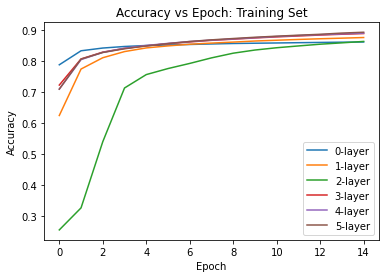

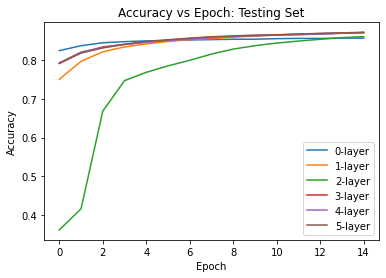

In [65]:
mlp3Layer = MLP(
    LinearLayerX(28**2, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt3 = GradientDescentOptimizer(mlp3Layer, LEARNING_RATE)

mlp4Layer = MLP(
    LinearLayerX(28**2, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt4 = GradientDescentOptimizer(mlp4Layer, LEARNING_RATE)

mlp5Layer = MLP(
    LinearLayerX(28**2, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt5 = GradientDescentOptimizer(mlp5Layer, LEARNING_RATE)

mlp3, losses_train, losses_valid, acc_train, acc_valid = mlp3Layer.fit(opt3, x_train, y_train, x_valid, y_valid, steps=GRADIENT_STEPS, batch_size=BATCH_SIZE)
grads = mlp3.check_gradient(x_train, y_train)
train_acc_layers.append(acc_train)
valid_test_acc_layers.append(acc_valid)

mlp4, losses_train, losses_valid, acc_train, acc_valid = mlp4Layer.fit(opt4, x_train, y_train, x_valid, y_valid, steps=GRADIENT_STEPS, batch_size=BATCH_SIZE)
grads = mlp4.check_gradient(x_train, y_train)
train_acc_layers.append(acc_train)
valid_test_acc_layers.append(acc_valid)

mlp5, losses_train, losses_valid, acc_train, acc_valid = mlp5Layer.fit(opt5, x_train, y_train, x_valid, y_valid, steps=GRADIENT_STEPS, batch_size=BATCH_SIZE)
grads = mlp5.check_gradient(x_train, y_train)
train_acc_layers.append(acc_train)
valid_test_acc_layers.append(acc_valid)


# Plot training accuracy over 0 to 4 hidden layers
plt.clf()
plt.plot(train_acc_layers[0], label = "0-layer")
plt.plot(train_acc_layers[1], label = "1-layer")
plt.plot(train_acc_layers[2], label = "2-layer")
plt.plot(train_acc_layers[3], label = "3-layer")
plt.plot(train_acc_layers[4], label = "4-layer")
plt.plot(train_acc_layers[5], label = "5-layer")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title(f"Accuracy vs Epoch: Training Set")
plt.savefig(f"training_vs_valid_acc_diff_layers_train.png", bbox_inches="tight", dpi=300)
plt.show()

# Plot testing accuracy over 0 to 4 hidden layers
plt.clf()
plt.plot(valid_test_acc_layers[0], label = "0-layer")
plt.plot(valid_test_acc_layers[1], label = "1-layer")
plt.plot(valid_test_acc_layers[2], label = "2-layer")
plt.plot(valid_test_acc_layers[3], label = "3-layer")
plt.plot(valid_test_acc_layers[4], label = "4-layer")
plt.plot(valid_test_acc_layers[5], label = "5-layer")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title(f"Accuracy vs Epoch: Testing Set")
plt.savefig(f"training_vs_valid_acc_diff_layers_test.png", bbox_inches="tight", dpi=300)
plt.show()

## Changing the width of hidden layers as we go deeper

  7%|▋         | 1/15 [00:42<09:54, 42.44s/it]

iteration 0: train loss 2.2998417848171626, train acc 0.11445833333333329, valid loss 2.293894930876316, valid acc 0.21466666666666667 


 13%|█▎        | 2/15 [01:22<08:52, 40.98s/it]

iteration 1: train loss 2.1283676771135496, train acc 0.2804583333333332, valid loss 1.7849566841368247, valid acc 0.3105 


 20%|██        | 3/15 [02:07<08:33, 42.81s/it]

iteration 2: train loss 1.3427956939283618, train acc 0.4532916666666668, valid loss 1.0624048133442383, valid acc 0.5441666666666667 


 27%|██▋       | 4/15 [02:48<07:43, 42.16s/it]

iteration 3: train loss 0.9224289653093931, train acc 0.6284791666666661, valid loss 0.8126346828033082, valid acc 0.706 


 33%|███▎      | 5/15 [03:25<06:41, 40.13s/it]

iteration 4: train loss 0.7229038692023083, train acc 0.730791666666667, valid loss 0.6571544213836038, valid acc 0.7591666666666667 


 40%|████      | 6/15 [04:04<05:58, 39.86s/it]

iteration 5: train loss 0.6112790241253521, train acc 0.7665416666666661, valid loss 0.5850567200110597, valid acc 0.7794166666666666 


 47%|████▋     | 7/15 [04:43<05:16, 39.59s/it]

iteration 6: train loss 0.5562626512734539, train acc 0.7853124999999994, valid loss 0.5450205081662591, valid acc 0.79325 


 53%|█████▎    | 8/15 [05:24<04:39, 39.95s/it]

iteration 7: train loss 0.5207425462079031, train acc 0.8011666666666668, valid loss 0.5169161351844166, valid acc 0.8024166666666667 


 60%|██████    | 9/15 [06:04<04:01, 40.19s/it]

iteration 8: train loss 0.4933392002970535, train acc 0.815250000000001, valid loss 0.4929253543113247, valid acc 0.81625 


 67%|██████▋   | 10/15 [06:44<03:20, 40.11s/it]

iteration 9: train loss 0.46860254925007055, train acc 0.8300208333333331, valid loss 0.470319021375592, valid acc 0.8303333333333334 


 73%|███████▎  | 11/15 [07:23<02:39, 39.78s/it]

iteration 10: train loss 0.44602794881453584, train acc 0.8397708333333335, valid loss 0.4507544753223693, valid acc 0.8390833333333333 


 80%|████████  | 12/15 [08:05<02:00, 40.26s/it]

iteration 11: train loss 0.4268678398842576, train acc 0.847020833333334, valid loss 0.43482454940402765, valid acc 0.84525 


 87%|████████▋ | 13/15 [08:45<01:20, 40.18s/it]

iteration 12: train loss 0.41066639663501203, train acc 0.8525416666666668, valid loss 0.42172442967975304, valid acc 0.84875 


 93%|█████████▎| 14/15 [09:23<00:39, 39.72s/it]

iteration 13: train loss 0.3968527278545435, train acc 0.8575208333333338, valid loss 0.41064914508744393, valid acc 0.853 


100%|██████████| 15/15 [10:00<00:00, 40.04s/it]

iteration 14: train loss 0.38496186876924104, train acc 0.8623750000000007, valid loss 0.40140298445672806, valid acc 0.8559166666666667 


Weight gradient difference: [4.9962141334134494e-20, 4.9589665467791954e-20, 5.117994394582984e-20]
Biases gradient difference: [5.085797727207756e-17, 5.2375208527486695e-17, 5.900829746752549e-17]


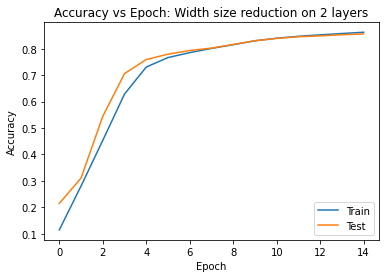

  7%|▋         | 1/15 [00:41<09:35, 41.09s/it]

iteration 0: train loss 1.0943242965230617, train acc 0.6368124999999999, valid loss 0.6856091000595561, valid acc 0.7600833333333333 


 13%|█▎        | 2/15 [01:20<08:43, 40.24s/it]

iteration 1: train loss 0.6140767089089147, train acc 0.7795416666666669, valid loss 0.5625257249860961, valid acc 0.7990833333333334 


 20%|██        | 3/15 [01:56<07:35, 38.00s/it]

iteration 2: train loss 0.5266161008817091, train acc 0.8116458333333335, valid loss 0.5096012754222233, valid acc 0.8168333333333333 


 27%|██▋       | 4/15 [02:31<06:45, 36.88s/it]

iteration 3: train loss 0.4822770972418778, train acc 0.8272083333333335, valid loss 0.4803168051959152, valid acc 0.8274166666666667 


 33%|███▎      | 5/15 [03:05<06:00, 36.04s/it]

iteration 4: train loss 0.454136782003032, train acc 0.8367708333333332, valid loss 0.46098678685253125, valid acc 0.8345 


 40%|████      | 6/15 [03:40<05:20, 35.63s/it]

iteration 5: train loss 0.4334596278391193, train acc 0.8439583333333329, valid loss 0.44669969525155, valid acc 0.8404166666666667 


 47%|████▋     | 7/15 [04:14<04:41, 35.13s/it]

iteration 6: train loss 0.4169969854276084, train acc 0.8505416666666668, valid loss 0.43525354810653244, valid acc 0.8438333333333333 


 53%|█████▎    | 8/15 [04:52<04:11, 35.91s/it]

iteration 7: train loss 0.40328846935771495, train acc 0.8560416666666671, valid loss 0.42587537710635387, valid acc 0.8480833333333333 


 60%|██████    | 9/15 [05:27<03:34, 35.73s/it]

iteration 8: train loss 0.3914651548803851, train acc 0.8598541666666669, valid loss 0.4176846394393014, valid acc 0.8514166666666667 


 67%|██████▋   | 10/15 [06:02<02:58, 35.61s/it]

iteration 9: train loss 0.38109572846488354, train acc 0.863604166666667, valid loss 0.4105620069022476, valid acc 0.8540833333333333 


 73%|███████▎  | 11/15 [06:37<02:21, 35.36s/it]

iteration 10: train loss 0.371843914606362, train acc 0.8671041666666661, valid loss 0.4042687472464019, valid acc 0.8575 


 80%|████████  | 12/15 [07:13<01:46, 35.54s/it]

iteration 11: train loss 0.3634666183832308, train acc 0.8700625000000003, valid loss 0.39877836306783365, valid acc 0.8598333333333333 


 87%|████████▋ | 13/15 [07:48<01:10, 35.23s/it]

iteration 12: train loss 0.35577985271344176, train acc 0.8728125000000002, valid loss 0.39387180480643025, valid acc 0.8615833333333334 


 93%|█████████▎| 14/15 [08:23<00:35, 35.16s/it]

iteration 13: train loss 0.34866186583006853, train acc 0.8747500000000004, valid loss 0.38942550863402486, valid acc 0.8633333333333333 


100%|██████████| 15/15 [09:00<00:00, 36.04s/it]

iteration 14: train loss 0.3419431393536299, train acc 0.8775000000000005, valid loss 0.38540266654609073, valid acc 0.8648333333333333 
Weight gradient difference: []
Biases gradient difference: []


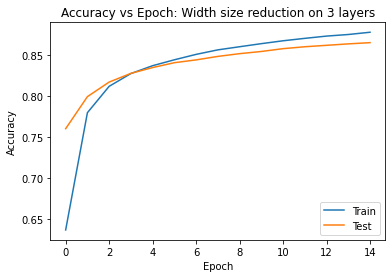

In [68]:
# HIDDEN_SIZE = 128
mlp2Layer = MLP(
    LinearLayer(28**2, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE//2),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE//2, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2Layer, LEARNING_RATE)


mlp3Layer = MLP(
    LinearLayerX(28**2, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE, HIDDEN_SIZE//2),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE//2, HIDDEN_SIZE//4),
    ReLULayer(),
    LinearLayerX(HIDDEN_SIZE//4, 10),
    SoftmaxOutputLayer()
)
opt3 = GradientDescentOptimizer(mlp3Layer, LEARNING_RATE)



mlp2, losses_train, losses_valid, acc_train, acc_valid = mlp2Layer.fit(opt2, x_train, y_train, x_valid, y_valid, steps=15, batch_size = BATCH_SIZE)
grads = mlp2.check_gradient(x_train, y_train)
plt.clf()
plt.plot(acc_train, label = "Train")
plt.plot(acc_valid, label = "Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title("Accuracy vs Epoch: Width size reduction on 2 layers")
plt.savefig("training_vs_valid_acc_width_reduction_2_layers.png", bbox_inches="tight", dpi=300)
plt.show()

mlp3, losses_train, losses_valid, acc_train, acc_valid = mlp3Layer.fit(opt3, x_train, y_train, x_valid, y_valid, steps=15, batch_size = BATCH_SIZE)
grads = mlp3.check_gradient(x_train, y_train)
plt.clf()
plt.plot(acc_train, label = "Train")
plt.plot(acc_valid, label = "Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title("Accuracy vs Epoch: Width size reduction on 3 layers")
plt.savefig("training_vs_valid_acc_width_reduction_3_layers.png", bbox_inches="tight", dpi=300)
plt.show()

## Our MLP model with the best parameters

Number of hidden layers: 1

Activation Function: ReLU

L2-Regularization: No

Number of epochs: 15

Normalize data: No

Width reduction: No

  7%|▋         | 1/15 [00:30<07:10, 30.76s/it]

iteration 0: train loss 1.2341213566398788, train acc 0.636166666666666, valid loss 0.7130151796827624, valid acc 0.7510833333333333 


 13%|█▎        | 2/15 [01:02<06:50, 31.58s/it]

iteration 1: train loss 0.6173852362930684, train acc 0.7759374999999998, valid loss 0.5555062486854775, valid acc 0.7961666666666667 


 20%|██        | 3/15 [01:33<06:13, 31.12s/it]

iteration 2: train loss 0.5173601055002851, train acc 0.8131458333333333, valid loss 0.4934246084464866, valid acc 0.82125 


 27%|██▋       | 4/15 [02:05<05:46, 31.50s/it]

iteration 3: train loss 0.4693369348365136, train acc 0.8326666666666664, valid loss 0.45914451973042714, valid acc 0.834 


 33%|███▎      | 5/15 [02:36<05:11, 31.14s/it]

iteration 4: train loss 0.44051223584660293, train acc 0.8434791666666669, valid loss 0.4372528428434467, valid acc 0.8411666666666666 


 40%|████      | 6/15 [03:08<04:43, 31.48s/it]

iteration 5: train loss 0.4207455066576599, train acc 0.8505625000000001, valid loss 0.4218693033727143, valid acc 0.8475833333333334 


 47%|████▋     | 7/15 [03:51<04:41, 35.22s/it]

iteration 6: train loss 0.40584255578351436, train acc 0.8549166666666661, valid loss 0.4103266212734461, valid acc 0.8525 


 53%|█████▎    | 8/15 [04:31<04:18, 36.88s/it]

iteration 7: train loss 0.39379226686566465, train acc 0.8600416666666673, valid loss 0.40113730690469795, valid acc 0.8565 


 60%|██████    | 9/15 [05:05<03:36, 36.08s/it]

iteration 8: train loss 0.383608024602428, train acc 0.8636041666666671, valid loss 0.39339211549131003, valid acc 0.8595833333333334 


 67%|██████▋   | 10/15 [05:41<02:59, 35.93s/it]

iteration 9: train loss 0.37481854292767885, train acc 0.8668333333333333, valid loss 0.38687899809016446, valid acc 0.86175 


 73%|███████▎  | 11/15 [06:16<02:22, 35.64s/it]

iteration 10: train loss 0.36707446157212664, train acc 0.8696875, valid loss 0.381293907521485, valid acc 0.8644166666666667 


 80%|████████  | 12/15 [06:49<01:44, 34.90s/it]

iteration 11: train loss 0.3601707266951138, train acc 0.8719583333333337, valid loss 0.37639845939042826, valid acc 0.86675 


 87%|████████▋ | 13/15 [07:21<01:07, 33.90s/it]

iteration 12: train loss 0.35394268847547666, train acc 0.8738958333333335, valid loss 0.37210188516608667, valid acc 0.868 


 93%|█████████▎| 14/15 [07:54<00:33, 33.60s/it]

iteration 13: train loss 0.3482561341950587, train acc 0.8760208333333337, valid loss 0.36813592515338117, valid acc 0.8699166666666667 


100%|██████████| 15/15 [08:28<00:00, 33.92s/it]

iteration 14: train loss 0.3429669990420666, train acc 0.8776875000000001, valid loss 0.3645574644731695, valid acc 0.8706666666666667 


Weight gradient difference: [5.014529193095161e-20, 4.993926482871807e-20]
Biases gradient difference: [5.300640097194146e-17, 3.9473779779555194e-17]


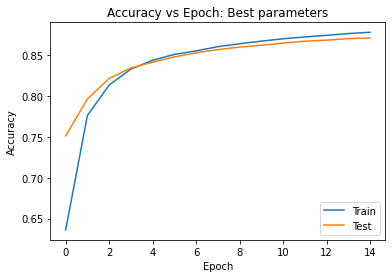

In [69]:
mlp1 = MLP(
    LinearLayer(28**2, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, LEARNING_RATE)

mlp, losses_train, losses_valid, acc_train, acc_valid = mlp1.fit(opt1, x_train, y_train, x_valid, y_valid, steps=15, batch_size = BATCH_SIZE)
grads = mlp.check_gradient(x_train, y_train)

plt.clf()
plt.plot(acc_train, label = "Train")
plt.plot(acc_valid, label = "Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title("Accuracy vs Epoch: Best parameters")
plt.savefig("training_vs_valid_acc_best_params.png", bbox_inches="tight", dpi=300)
plt.show()
